In [1]:
 '''
Author information:
Joey R. Muffoletto
University of Texas at Austin
Autonomous Systems Group
jrmuff@utexas.edu
'''

'\nAuthor information:\nJoey R. Muffoletto\nUniversity of Texas at Austin\nAutonomous Systems Group\njrmuff@utexas.edu\n'

In [2]:
# import dill
# dill.load_session('realtime_notebook_PURDUE_data.db')

C:\Users\Joey\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Joey\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\Joey\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


In [3]:
import os

import realtime_manager as rm 
import graph_manager as gm
import reworked_graph as rg
import pandas as pd
import numpy as np
import copy

# os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz 2.44.1/bin'

C:\Users\Joey\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Joey\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\Joey\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


In [4]:
'''
manager configurations

traffic test globals
'''

USE_PURDUE_DATA = True
MAX_ALLOWED_REQUESTS = 7

MIN_TOWERS = 2
NUM_VERTIHUBS = 64
TAU_MAX = 8
TAU = 0

FREQUENCY_MULTIPLIERS = [2]
FREQUENCY_MULTIPLIER = 1

LOW_TRAFFIC_MULTIPLIER = 1
HIGH_TRAFFIC_MULTIPLIER = 3

MIN_LOW_TRAFFIC = 0
MAX_LOW_TRAFFIC = LOW_TRAFFIC_MULTIPLIER * int(NUM_VERTIHUBS * FREQUENCY_MULTIPLIER)

MIN_HIGH_TRAFFIC = MAX_LOW_TRAFFIC
MAX_HIGH_TRAFFIC = HIGH_TRAFFIC_MULTIPLIER * int(NUM_VERTIHUBS * FREQUENCY_MULTIPLIER)

MIN_TTL = 3
MAX_TTL = 7

FLIGHT_SPEED = 60 # m/s



DEFAULT_EMPTY_STATE = rg.State((),(),{"0" : 6})
rm.configure_realtime(tau=TAU, override_default_empty_state=DEFAULT_EMPTY_STATE)

# HIGH_TRAFFIC_FREQUENCY = .1 # use rand.random() = [0.0, 1.0], or, just add this value until = 1 then reset
HIGH_TRAFFIC_TRIGGER = 8
NUM_TIME_STEPS = 20



In [5]:
'''
Input generation functions

low traffic is some random number between min_low_traffic and max_low_traffic, high traffic is the same with high

choose a random tower index everytime we add one

high traffic occurs everytime HIGH_TRAFFIC_FREQUENCY * TIME_STEPS is a whole number

TTL is a random number between MIN_TTL and MAX_TTL

Output format is a dictionary which maps tower index to a list of requests (tuples of preferred port and TTL )

This ouput is created per time step, so then the overall input is a list of these dictionaries, with each list index corresponding to the step of the simulation.

'''
import random
random.seed(10)
def generate_traffic(min_traffic, max_traffic):
    additional_requests_dict = dict()
#     counter = 0
    requests_to_add = random.randint(min_traffic, max_traffic)
    for i in range(requests_to_add):
#         if counter == NUM_VERTIHUBS:
#             counter = 0
#         tower_to_add_to = counter
#         counter+=1
        tower_to_add_to = random.randint(0, NUM_VERTIHUBS-1) # NUM_VERTIHUBS is OOB
        request_to_add = ('no_pref', random.randint(MIN_TTL, MAX_TTL))
#         request_to_add = ('no_pref', 5)
        if tower_to_add_to in additional_requests_dict:
            additional_requests_dict[tower_to_add_to].append(request_to_add)
        else:
            additional_requests_dict[tower_to_add_to] = [request_to_add]
    return additional_requests_dict
            
def generate_low_traffic():
    return generate_traffic(MIN_LOW_TRAFFIC, MAX_LOW_TRAFFIC)
    
def generate_high_traffic():
    return generate_traffic(MIN_HIGH_TRAFFIC, MAX_HIGH_TRAFFIC)

In [6]:
'''
Input Generation
'''
def generate_inputs():
    input = []
    high_traffic_counter = 1
    for time in range(NUM_TIME_STEPS):
        if high_traffic_counter == HIGH_TRAFFIC_TRIGGER:
            high_traffic_counter = 1
            input.append([generate_high_traffic()])
        else:
            high_traffic_counter += 1
            input.append([generate_low_traffic()])

    initial_system = [copy.deepcopy(gm.return_tower(0, 1, [],[6])) for i in range(NUM_VERTIHUBS)]
    return initial_system, input

In [7]:
'''
Input statistics:
'''
def generate_input_statistics(input):
    requests_per_tower = [0 for i in range(NUM_VERTIHUBS)]
    for time_step in range(len(input)):
        for i in range(NUM_VERTIHUBS):
            if i in input[time_step][0]:
                requests_per_tower[i]+=len(input[time_step][0][i])
    for i in range(NUM_VERTIHUBS):
        print("tower " + str(i) + "has " + str(requests_per_tower[i]) + " requests")
    average_input_frequency = sum([i for i in requests_per_tower])/(float(NUM_TIME_STEPS) * float(NUM_VERTIHUBS))
    print("average_input_frequency = " + str(average_input_frequency))
    return average_input_frequency

In [8]:
#purdue data methods
if USE_PURDUE_DATA == True:
    import random
    class Purdue_Data_Output:
        def __init__(self):
            self.num_denied_requests = 0
            self.additional_requests_culled = 0
            self.max_requests = 0
            
    from math import cos, asin, sqrt, pi

    def ll_distance(lat1, lon1, lat2, lon2):
        p = pi/180
        a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p) * cos(lat2*p) * (1-cos((lon2-lon1)*p))/2
        return 12742 * asin(sqrt(a)) #2*R*asin...   
        
    # make a list of lists of dictionaries which map tower indicies to requests
    def vertiport_statistics(vertiports_data):
        '''
        vertiport statistics
        '''
        vertiports_per_vertihub = [0 for i in range(NUM_VERTIHUBS)]
        for index, vertiport in vertiports_data.iterrows():
#             print((int(vertiport['vertihub'])))
            vertiports_per_vertihub[int(vertiport['vertihub'])] += 1
        assert(sum(vertiports_per_vertihub) == vertiports_data.shape[0])
        vertiports_per_vertihub
    
    def trip_statistics(trip_data, vertiports_data):
        '''
        trip statistics
        '''
        arrivals_per_vertihub = [[] for i in range(NUM_VERTIHUBS)]
        flight_popularity = dict()
        # get the trip arrival time per vertihub
        for index, trip in trip_data.iterrows():
            #calculate time of arrival (begin at trip.time), calculated between vertiports
            origin_port = vertiports_data.iloc[trip['OriginVertiport']]
            destination_port = vertiports_data.iloc[trip['DestinationVertiport']]
            if((origin_port['vertiport'],destination_port['vertiport']) not in flight_popularity.keys()):
                flight_popularity[(origin_port['vertiport'], destination_port['vertiport'])] = 1
            else:
                flight_popularity[(origin_port['vertiport'], destination_port['vertiport'])] += 1
            #trip distance in kilometers
            dist = ll_distance(origin_port['lat'], origin_port['long'], destination_port['lat'], destination_port['long'])
            travel_time = (dist*1000)/FLIGHT_SPEED # (km * 1000)/(m/s) -> seconds
            arrival_time = trip['Time'] + travel_time #takeoff time + travel_time = arrival time
            #add arrival time to vertihub
            arrivals_per_vertihub[trip['DestinationVertihub']].append(arrival_time)
        
        # for each list of vertihub, calculate the minimum, average, and maximum distance between arrivals
        differences_per_vertihub = []
        # simulated_arrivals
        for arrivals_list in arrivals_per_vertihub:
            sorted_arrivals = sorted(arrivals_list)
            if(len(sorted_arrivals) <= 1):
                continue
            differences = []
            for index in range(len(sorted_arrivals)-1):
                differences.append(sorted_arrivals[index+1] - sorted_arrivals[index])
            print(sorted_arrivals)
            differences_per_vertihub.append(sorted(differences))
        
        for index, differences in enumerate(differences_per_vertihub):
            print('vertihub ' + str(index) + ' has minimum arrival difference of ' + str(differences[0]))
            print('vertihub ' + str(index) + ' has average arrival difference of ' + str(sum(differences)/len(differences)))
            print('vertihub ' + str(index) + ' has maximum arrival difference of ' + str(differences[len(differences)-1]))
            print('vertihub ' + str(index) + ' has ' + str(len(differences)) + ' trips')
            print('')
           
        
        formatted_flight_popularity = [(flight_popularity[key], key) for key in flight_popularity.keys()]
        print('Most popular flight path ' + str((sorted(formatted_flight_popularity))[len(formatted_flight_popularity)-1]))
        print('Total flight paths ' + str(len(formatted_flight_popularity)))
        avg = sum([num for num, thing in formatted_flight_popularity])/len(formatted_flight_popularity)
        print('Mean requests per flight path ' + str(avg))
    
    def load_vertiport_data(display_stats=True):
        vertiports_data = pd.read_csv('data/Realtime/OpsLimits/vertiports_' + str(NUM_VERTIHUBS) + '.csv')
        if display_stats:
            vertiport_statistics(vertiports_data)
        return vertiports_data
    def load_trip_data(vertiports_data, display_stats=True):
        trip_data = pd.read_csv('data/Realtime/OpsLimits/trips_32.csv')
        trip_data.drop(trip_data[trip_data.OriginVertihub == trip_data.DestinationVertihub].index, inplace=True) #drop trips where the origin and destination are the same vertiport, reduced from 4801 trips to 1692 with 10 vertiports
        if display_stats:
            trip_statistics(trip_data, vertiports_data)
        return trip_data
    
    def format_purdue_dataset():
        vertiports_data = load_vertiport_data()
        trip_data = load_trip_data(vertiports_data)
        arrivals_per_vertihub = [[] for i in range(NUM_VERTIHUBS)]
        # get the trip arrival time per vertihub
        latest_arrival_time = -1
        for index, trip in trip_data.iterrows():
            #calculate time of arrival (begin at trip.time), calculated between vertiports
            origin_port = vertiports_data.iloc[trip['OriginVertiport']]
            destination_port = vertiports_data.iloc[trip['DestinationVertiport']]
            #trip distance in kilometers
            dist = ll_distance(origin_port['lat'], origin_port['long'], destination_port['lat'], destination_port['long'])
            travel_time = (dist*1000)/FLIGHT_SPEED # (km * 1000)/(m/s) -> seconds
            arrival_time = trip['Time'] + travel_time #takeoff time + travel_time = arrival time
            if(arrival_time > latest_arrival_time):
                latest_arrival_time = arrival_time
            #add arrival time to vertihub
            arrivals_per_vertihub[trip['DestinationVertihub']].append((int(arrival_time), 
                                                                       int(destination_port['vertihub']), 
                                                                           int(destination_port['vertiport']
                                                                              )))
        #build input list
        input = [[dict()] for i in range(int(latest_arrival_time)+1)]
        for arrivals in arrivals_per_vertihub:
            for arrival in arrivals:
                arrival_time, destination_hub, destination_port = arrival
                randomized_TTL = random.randint(MIN_TTL, MAX_TTL)
                to_add = (('' + str(destination_port)), randomized_TTL) # (destination port, time to land)
                if destination_hub not in input[arrival_time][0].keys():
                    input[arrival_time][0][destination_hub] = []
                #TODO: CHANGE THIS EVENTUALLY!!!!!
                if(len(input[arrival_time][0][destination_hub]) < 100): 
                    input[arrival_time][0][destination_hub].append(to_add)
          
        #build vertihub list
        initial_vertihubs = []
        for vertihub_index in range(NUM_VERTIHUBS):
            #TODO: fix this... replace 'no_pref' with vertiport_index and figure out the issue with your legacy code! :)
            port_dict = {'no_pref' : 3 for vertiport_index, trip in vertiports_data.iterrows() if trip['vertihub'] == vertihub_index}
            accepted_requests_per_time_step = 1
            request_vector = []
            time_vec = []
            vertihub = gm.return_tower_specific(port_dict, accepted_requests_per_time_step, request_vector, time_vec)
            initial_vertihubs.append(vertihub)
        return initial_vertihubs, input
                          
                
                
                                        
    

In [9]:
'''
data collection functions
'''
def run_realtime_data_collection(initial_system_copy, input_copy, PDOs=None):
    gm.reset_globals()
    global MAX_ALLOWED_REQUESTS
    
    _completed_states_per_tau = [[] for i in range(TAU_MAX)]
    _timing_info_per_tau = [[] for i in range(TAU_MAX)]
    for _tau in range(TAU_MAX):
        rm.configure_realtime(tau=_tau, override_default_empty_state=DEFAULT_EMPTY_STATE)
        traces = None
        timings = None
        if not USE_PURDUE_DATA:
            traces, timings = rm.main_loop(initial_system_copy, copy.deepcopy(input_copy))
        else:
            #NOTE: when using the Purdue data, we will be deleting requests that were denied during runs with higher TAUs.
            # that is why we are no longer making a copy of the input_copy, and instead passing the direct reference to be modified
            print("INPUT STATISTICS FOR TAU : " + str(_tau))
            generate_input_statistics(input_copy)
            curr_PDO = PDOs[_tau]
            traces, timings = rm.main_loop(initial_system_copy, input_copy, MAX_ALLOWED_REQUESTS=MAX_ALLOWED_REQUESTS, Purdue_Data_Output=curr_PDO)
#             if _tau == 0:
            input_copy = curr_PDO.additional_requests_culled
#                 MAX_ALLOWED_REQUESTS = 100 #because fuck the next guys
        _completed_states_per_tau[_tau] = copy.deepcopy(traces)
        _timing_info_per_tau[_tau] = copy.deepcopy(timings)
        gm.reset_globals()
    return _completed_states_per_tau, _timing_info_per_tau
    #     print(traces)
        # _completed_states, _timing_info = rm.main_loop(initial_system_copy, input_copy)


In [10]:
'''
data collection pipeline
'''
if USE_PURDUE_DATA:
    FREQUENCY_MULTIPLIERS = [1]
    TAU_MAX = 1 #just run it for the TAU = 0 case.

_completed_states_per_tau_per_freq = {freq : [] for freq in FREQUENCY_MULTIPLIERS}
_timing_info_per_tau_per_freq = {freq : [] for freq in FREQUENCY_MULTIPLIERS}
_actual_frequencies_per_freq = {freq : [] for freq in FREQUENCY_MULTIPLIERS}
NUM_TRIALS = 5
for freq in FREQUENCY_MULTIPLIERS:
    if not USE_PURDUE_DATA:
        # setting the frequency multipliers
        MAX_LOW_TRAFFIC = LOW_TRAFFIC_MULTIPLIER * int(NUM_VERTIHUBS * freq)
    
        MIN_HIGH_TRAFFIC = MAX_LOW_TRAFFIC
        MAX_HIGH_TRAFFIC = HIGH_TRAFFIC_MULTIPLIER * int(NUM_VERTIHUBS * freq)
        for i in range(NUM_TRIALS):
            initial_system, input = generate_inputs()
            input_frequency = generate_input_statistics(input) 
            _completed_states_per_tau, _timing_info_per_tau = run_realtime_data_collection(copy.deepcopy(initial_system), copy.deepcopy(input))
            _completed_states_per_tau_per_freq[freq].append(_completed_states_per_tau)
            _timing_info_per_tau_per_freq[freq].append(_timing_info_per_tau)
            _actual_frequencies_per_freq[freq].append(input_frequency)
    else:
        initial_system, _input = format_purdue_dataset() #Purdue dataset
        print(_input)
        PDOs = [Purdue_Data_Output() for i in range(TAU_MAX)]
        input_frequency = generate_input_statistics(_input) 
        _completed_states_per_tau, _timing_info_per_tau = run_realtime_data_collection(copy.deepcopy(initial_system), copy.deepcopy(_input), PDOs=PDOs)
        _completed_states_per_tau_per_freq[freq].append(_completed_states_per_tau)
        _timing_info_per_tau_per_freq[freq].append(_timing_info_per_tau)
        _actual_frequencies_per_freq[freq].append(input_frequency)
        
        for _tau, pdo in enumerate(PDOs):
            print("DENIED REQUESTS, MAX_REQUESTS, TAU " + str(pdo.num_denied_requests) + ", " + str(pdo.max_requests) + ", " + str(_tau))

[132.65059690753577, 191.59457551128185, 197.30515121902187, 215.6342445913684, 215.6342445913684, 219.81365845901982, 219.81365845901982, 236.2739944485188, 296.2739944485188, 306.1248374998985, 307.146617278979, 307.146617278979, 312.28404171279124, 317.30515121902187, 320.7547246966561, 327.1947225711058, 339.81365845901985, 339.81365845901985, 339.81365845901985, 366.1248374998985, 366.1248374998985, 370.65802181599895, 370.65802181599895, 370.65802181599895, 372.28404171279124, 372.28404171279124, 372.28404171279124, 375.77623315681427, 377.4228042254857, 380.06109054673135, 387.57351122536784, 399.81365845901985, 412.8425293081599, 416.2739944485188, 418.10595463158285, 421.3788580918694, 421.3788580918694, 421.3788580918694, 421.3788580918694, 421.3788580918694, 425.5808496375105, 427.146617278979, 427.146617278979, 428.9921382492506, 428.9921382492506, 428.9921382492506, 437.30515121902187, 437.30515121902187, 440.06109054673135, 440.85853561335415, 442.82072360929305, 447.5735

[[{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{44: [('128', 6)]}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{39: [('45', 7)]}], [{}], [{}], [{}], [{39: [('0', 7)]}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{39: [('106', 4)]}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{20: [('158', 3)]}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{}], [{50: [('157', 6)]}], [{}], [{}], [{16: [('66', 5)]}], [{}], [{}], [{}

Current time step : 85/4151
additional requests = [{44: [('128', 6)]}]
Current time step : 107/4151
additional requests = [{39: [('45', 7)]}]
Current time step : 111/4151
additional requests = [{39: [('0', 7)]}]
Current time step : 123/4151
additional requests = [{39: [('106', 4)]}]
Current time step : 132/4151
additional requests = [{20: [('158', 3)]}]
Current time step : 142/4151
additional requests = [{50: [('157', 6)]}]
Current time step : 145/4151
additional requests = [{16: [('66', 5)]}]
Current time step : 149/4151
additional requests = [{35: [('27', 6)]}]
Current time step : 163/4151
additional requests = [{56: [('144', 4)]}]
Current time step : 166/4151
additional requests = [{1: [('48', 5), ('48', 5), ('48', 5)], 31: [('21', 6)]}]
Current time step : 167/4151
additional requests = [{1: [('48', 6)]}]
Current time step : 176/4151
additional requests = [{0: [('93', 4)]}]
Current time step : 181/4151
additional requests = [{5: [('50', 4), ('50', 7)]}]
Current time step : 185/4151

Current time step : 327/4151
additional requests = [{33: [('86', 3)], 39: [('75', 4)]}]
Current time step : 328/4151
additional requests = [{9: [('116', 6)], 48: [('83', 3)]}]
Current time step : 330/4151
additional requests = [{44: [('114', 4), ('114', 3)]}]
Current time step : 331/4151
additional requests = [{5: [('88', 6), ('88', 5), ('88', 4), ('88', 7), ('121', 7)], 46: [('96', 4), ('96', 7), ('96', 6), ('96', 6), ('96', 6)]}]
Current time step : 334/4151
additional requests = [{48: [('132', 7)]}]
Current time step : 335/4151
additional requests = [{46: [('20', 7)]}]
Current time step : 339/4151
additional requests = [{33: [('117', 4), ('117', 7), ('117', 6)], 44: [('128', 4)]}]
Current time step : 340/4151
additional requests = [{17: [('46', 5), ('46', 4)], 42: [('55', 7)], 52: [('154', 3)]}]
Current time step : 341/4151
additional requests = [{38: [('104', 5)]}]
Current time step : 343/4151
additional requests = [{56: [('144', 4)]}]
Current time step : 344/4151
additional reques

Current time step : 428/4151
additional requests = [{33: [('117', 7), ('117', 3), ('117', 6)], 21: [('102', 4), ('102', 5)], 15: [('53', 7)], 40: [('28', 7)], 56: [('130', 6)]}]
Current time step : 430/4151
additional requests = [{1: [('48', 7)], 44: [('114', 6), ('114', 3), ('114', 7), ('114', 7), ('114', 3), ('114', 7), ('128', 7), ('128', 6)], 45: [('19', 6)]}]
DENIED REQUEST
Current time step : 431/4151
additional requests = [{48: [('83', 6), ('83', 4)]}]
Current time step : 432/4151
additional requests = [{39: [('137', 5)]}]
Current time step : 433/4151
additional requests = [{44: [('128', 7)], 50: [('157', 4), ('157', 7)]}]
Current time step : 435/4151
additional requests = [{39: [('137', 7)], 56: [('17', 4)]}]
Current time step : 436/4151
additional requests = [{26: [('103', 5)], 43: [('64', 6), ('64', 5), ('64', 6)]}]
Current time step : 437/4151
additional requests = [{20: [('158', 5), ('158', 4)]}]
Current time step : 439/4151
additional requests = [{33: [('29', 3)], 61: [('1

Current time step : 510/4151
additional requests = [{31: [('21', 5)], 40: [('38', 6), ('38', 7)]}]
Current time step : 511/4151
additional requests = [{5: [('88', 4), ('88', 7)], 46: [('96', 4)]}]
Current time step : 513/4151
additional requests = [{44: [('141', 5)], 41: [('89', 4)], 39: [('106', 7)]}]
Current time step : 514/4151
additional requests = [{44: [('114', 3)], 41: [('145', 4), ('145', 5), ('145', 5), ('145', 5)], 40: [('38', 7)]}]
Current time step : 515/4151
additional requests = [{33: [('117', 6), ('117', 4), ('117', 6)], 32: [('92', 5)], 46: [('110', 7), ('110', 5), ('20', 7), ('20', 7)], 1: [('48', 6)], 39: [('137', 3)]}]
Current time step : 517/4151
additional requests = [{33: [('117', 7)], 35: [('27', 3)], 24: [('127', 6)], 48: [('36', 7), ('36', 7)], 40: [('124', 7)]}]
Current time step : 518/4151
additional requests = [{22: [('3', 4)]}]
Current time step : 519/4151
additional requests = [{33: [('117', 4)], 18: [('68', 6)], 35: [('149', 3)], 44: [('128', 3), ('128', 

Current time step : 574/4151
additional requests = [{41: [('145', 4), ('145', 6)], 48: [('132', 6)], 40: [('38', 3), ('38', 6), ('38', 6), ('38', 5), ('38', 5), ('38', 6), ('38', 3)]}]
Current time step : 575/4151
additional requests = [{33: [('117', 3), ('117', 5), ('117', 3), ('117', 7), ('117', 3), ('117', 6), ('117', 3)], 32: [('92', 6)], 46: [('110', 6), ('20', 6)], 1: [('48', 6), ('48', 6), ('48', 4), ('48', 7)], 39: [('137', 7), ('137', 4)], 31: [('21', 5), ('21', 4), ('21', 4), ('21', 7), ('21', 3)]}]
Current time step : 577/4151
additional requests = [{41: [('89', 7), ('89', 6), ('89', 5)], 37: [('62', 4)], 48: [('36', 7)], 9: [('32', 6)]}]
Current time step : 578/4151
additional requests = [{22: [('3', 6)]}]
Current time step : 579/4151
additional requests = [{33: [('117', 6), ('117', 4)], 35: [('149', 3)]}]
Current time step : 580/4151
additional requests = [{58: [('1', 6)], 52: [('154', 5), ('154', 4)]}]
Current time step : 581/4151
additional requests = [{52: [('30', 5)], 

Current time step : 623/4151
additional requests = [{58: [('51', 4)], 29: [('85', 4), ('85', 6), ('85', 7)]}]
Current time step : 624/4151
additional requests = [{33: [('117', 7)], 43: [('61', 5)], 16: [('66', 7)], 5: [('2', 5)]}]
Current time step : 625/4151
additional requests = [{61: [('150', 4)], 44: [('141', 3), ('141', 5)], 16: [('66', 4)]}]
Current time step : 626/4151
additional requests = [{23: [('41', 6)], 54: [('131', 4)], 5: [('88', 7)], 46: [('110', 7)], 15: [('138', 4)], 50: [('157', 6)]}]
Current time step : 627/4151
additional requests = [{33: [('117', 7), ('86', 7)], 50: [('126', 6)], 18: [('24', 3), ('24', 5)], 48: [('36', 5)], 31: [('21', 7)], 9: [('32', 7)]}]
Current time step : 628/4151
additional requests = [{52: [('30', 4)], 12: [('120', 3)], 56: [('144', 5), ('144', 5)]}]
Current time step : 630/4151
additional requests = [{31: [('21', 4)]}]
Current time step : 631/4151
additional requests = [{5: [('88', 6), ('88', 7), ('121', 7)], 1: [('48', 4), ('48', 5), ('48

Current time step : 672/4151
additional requests = [{33: [('86', 5), ('86', 7), ('29', 5)], 8: [('57', 6)], 44: [('18', 7), ('18', 5)], 24: [('127', 6)], 25: [('97', 6)], 39: [('0', 3)], 56: [('31', 3)], 46: [('96', 3)]}]
Current time step : 673/4151
additional requests = [{54: [('39', 4)], 18: [('91', 7), ('91', 4)], 1: [('115', 5)], 21: [('40', 4)], 58: [('51', 5), ('51', 3)]}]
Current time step : 674/4151
additional requests = [{16: [('66', 6), ('66', 5), ('66', 5)], 61: [('134', 5), ('134', 5)]}]
Current time step : 675/4151
additional requests = [{26: [('103', 6)], 14: [('118', 6)], 44: [('114', 4), ('114', 5)], 39: [('137', 6), ('137', 6)], 37: [('62', 7)]}]
Current time step : 676/4151
additional requests = [{33: [('86', 4), ('86', 4), ('86', 5)], 26: [('103', 5)], 43: [('64', 7), ('64', 6), ('64', 7)], 16: [('66', 3), ('66', 4)], 39: [('137', 3), ('137', 3)], 18: [('24', 7), ('24', 6), ('24', 6)]}]
Current time step : 677/4151
additional requests = [{59: [('56', 6)]}]
Current t

Current time step : 722/4151
additional requests = [{28: [('78', 7), ('78', 4), ('78', 4), ('78', 5), ('78', 3)], 12: [('139', 6)], 39: [('45', 5), ('75', 6)], 18: [('151', 5)], 40: [('38', 7), ('38', 3), ('38', 6), ('38', 3)], 31: [('21', 4)], 56: [('31', 4)], 9: [('32', 4), ('32', 3)]}]
DENIED REQUEST
DENIED REQUEST
Current time step : 724/4151
additional requests = [{33: [('86', 6), ('86', 5)], 56: [('31', 4)]}]
Current time step : 725/4151
additional requests = [{44: [('141', 3), ('141', 4)], 2: [('98', 3)], 9: [('116', 5), ('116', 5), ('116', 5)], 56: [('144', 7), ('144', 4)], 50: [('126', 3)], 18: [('24', 7), ('24', 6), ('24', 5)]}]
Current time step : 726/4151
additional requests = [{20: [('158', 3), ('73', 6), ('73', 6)], 26: [('103', 5), ('103', 7), ('103', 5)], 21: [('102', 4)], 15: [('138', 7)], 35: [('149', 3)]}]
Current time step : 727/4151
additional requests = [{25: [('9', 4), ('97', 3), ('97', 7), ('97', 7)], 9: [('32', 6), ('32', 7), ('32', 5), ('32', 3)], 58: [('51', 

Current time step : 768/4151
additional requests = [{21: [('102', 3)], 58: [('1', 5)], 56: [('144', 7)], 48: [('83', 7)], 39: [('45', 3)], 31: [('21', 5)]}]
Current time step : 770/4151
additional requests = [{37: [('108', 7), ('108', 5), ('108', 7), ('108', 7)], 40: [('38', 3)], 56: [('17', 3)]}]
Current time step : 771/4151
additional requests = [{50: [('99', 3), ('99', 6), ('99', 6), ('99', 3), ('99', 5), ('99', 3), ('99', 3)], 11: [('54', 3)], 39: [('75', 4), ('75', 3), ('75', 6), ('75', 6)]}]
Current time step : 772/4151
additional requests = [{44: [('141', 6)], 20: [('14', 6)], 58: [('1', 7), ('1', 5), ('1', 5)], 48: [('83', 3)], 61: [('13', 4), ('13', 5), ('13', 6)], 56: [('130', 3), ('130', 5), ('130', 4)], 9: [('32', 3)]}]
Current time step : 773/4151
additional requests = [{33: [('29', 6), ('29', 5)], 1: [('115', 4), ('115', 6)], 43: [('61', 6), ('61', 6), ('61', 7)], 18: [('24', 5)], 40: [('38', 5), ('38', 6)]}]
Current time step : 774/4151
additional requests = [{21: [('102

Current time step : 815/4151
additional requests = [{33: [('117', 6), ('117', 5), ('117', 5), ('117', 7), ('117', 5), ('117', 3)], 1: [('48', 4), ('48', 5)], 44: [('114', 3)], 60: [('112', 7)], 31: [('21', 6), ('21', 5)]}]
Current time step : 816/4151
additional requests = [{1: [('115', 6)], 9: [('10', 7)], 46: [('20', 3)], 60: [('135', 7), ('135', 5)]}]
Current time step : 817/4151
additional requests = [{33: [('117', 6), ('117', 6), ('117', 5), ('117', 4), ('117', 4)], 44: [('141', 7), ('128', 7), ('128', 4)], 28: [('26', 5), ('26', 6), ('26', 5)], 14: [('42', 4)], 16: [('5', 7)], 48: [('83', 3), ('83', 5)], 37: [('62', 3), ('62', 7)], 58: [('51', 6)]}]
DENIED REQUEST
DENIED REQUEST
Current time step : 818/4151
additional requests = [{37: [('108', 6)], 46: [('34', 3), ('34', 3), ('34', 4)], 50: [('99', 4)], 44: [('114', 5)]}]
Current time step : 819/4151
additional requests = [{44: [('114', 6)], 42: [('55', 3)], 40: [('38', 6)], 46: [('96', 5)]}]
Current time step : 820/4151
addition

Current time step : 855/4151
additional requests = [{5: [('88', 3)], 26: [('103', 5), ('103', 6)], 14: [('118', 6), ('118', 5)], 2: [('98', 7), ('98', 6), ('98', 4), ('98', 4), ('98', 4), ('98', 6), ('98', 3), ('98', 6)], 44: [('114', 7)], 16: [('66', 4)], 37: [('62', 3), ('62', 5)], 51: [('90', 3), ('90', 7), ('90', 5), ('90', 7)], 0: [('93', 6), ('93', 3), ('93', 7), ('93', 4), ('93', 5)]}]
DENIED REQUEST
Current time step : 856/4151
additional requests = [{33: [('86', 7), ('86', 5), ('86', 5)], 16: [('66', 7), ('66', 4), ('66', 4)], 18: [('24', 4)]}]
Current time step : 857/4151
additional requests = [{21: [('102', 7)], 56: [('144', 6), ('17', 4)], 18: [('24', 6)], 51: [('90', 4)]}]
Current time step : 858/4151
additional requests = [{44: [('18', 3)], 62: [('77', 5)]}]
Current time step : 859/4151
additional requests = [{15: [('138', 7), ('138', 7), ('138', 4)], 39: [('137', 5)], 59: [('56', 6), ('56', 4), ('56', 3)]}]
Current time step : 860/4151
additional requests = [{32: [('92',

Current time step : 896/4151
additional requests = [{1: [('115', 5)], 56: [('144', 7), ('144', 6), ('144', 7)], 18: [('151', 6)], 9: [('32', 5), ('32', 5), ('32', 7), ('32', 5), ('32', 5), ('32', 4), ('32', 4), ('32', 3), ('32', 6)]}]
DENIED REQUEST
DENIED REQUEST
Current time step : 897/4151
additional requests = [{32: [('92', 7), ('92', 6), ('92', 3), ('92', 7), ('92', 3)], 54: [('39', 5), ('39', 6)], 56: [('144', 3), ('144', 5), ('144', 4)], 41: [('145', 4), ('145', 7)], 58: [('51', 5)], 40: [('124', 6)]}]
Current time step : 898/4151
additional requests = [{1: [('115', 5)], 60: [('112', 7)], 40: [('38', 3), ('38', 5)], 0: [('93', 7)]}]
Current time step : 899/4151
additional requests = [{32: [('92', 6)], 33: [('86', 5)], 43: [('61', 3)], 9: [('10', 7)], 37: [('62', 4), ('62', 4), ('62', 7)]}]
Current time step : 900/4151
additional requests = [{54: [('39', 6)], 33: [('117', 3), ('117', 3)], 63: [('59', 3), ('59', 3)], 11: [('82', 3), ('82', 5), ('82', 6)], 18: [('24', 6), ('24', 5)

Current time step : 935/4151
additional requests = [{33: [('117', 6), ('117', 6), ('117', 4), ('117', 6), ('117', 6), ('117', 4)], 46: [('110', 3)], 1: [('48', 6), ('48', 6), ('48', 6), ('48', 4), ('48', 7), ('48', 6), ('48', 7), ('48', 3), ('48', 6), ('48', 7), ('48', 6)], 14: [('118', 4), ('118', 7), ('118', 7), ('118', 7), ('42', 7)], 39: [('137', 7)], 18: [('68', 7)], 31: [('21', 3)], 40: [('38', 4), ('38', 3)], 56: [('17', 5), ('17', 6)]}]
DENIED REQUEST
DENIED REQUEST
DENIED REQUEST
DENIED REQUEST
Current time step : 936/4151
additional requests = [{46: [('34', 7), ('20', 6), ('20', 7)], 16: [('159', 7)], 21: [('102', 3)], 1: [('115', 5), ('115', 3)], 50: [('126', 4)], 9: [('10', 7)], 40: [('38', 6), ('38', 3)]}]
DENIED REQUEST
Current time step : 937/4151
additional requests = [{33: [('117', 6), ('117', 3)], 35: [('27', 6), ('27', 3)], 44: [('141', 7), ('141', 7), ('141', 7), ('128', 7)], 41: [('89', 6)], 28: [('26', 5)], 50: [('99', 3), ('126', 7), ('157', 5)], 25: [('97', 5)],

Current time step : 973/4151
additional requests = [{54: [('39', 4)], 58: [('1', 7)], 37: [('62', 7)]}]
Current time step : 974/4151
additional requests = [{33: [('86', 6), ('86', 7), ('29', 5)], 41: [('89', 5)], 14: [('118', 6), ('118', 7), ('118', 4), ('118', 3)], 16: [('66', 4)], 15: [('138', 3)], 39: [('137', 3), ('137', 3), ('137', 3)], 40: [('38', 6), ('38', 4), ('38', 6), ('38', 5), ('38', 7), ('38', 3), ('38', 4)], 59: [('56', 7), ('56', 4), ('56', 4)], 61: [('134', 4)]}]
Current time step : 975/4151
additional requests = [{26: [('103', 7), ('103', 4), ('103', 5), ('103', 5), ('103', 4)], 14: [('118', 3), ('118', 7), ('118', 3), ('118', 5)], 1: [('48', 6)], 2: [('98', 3), ('98', 6), ('98', 6), ('98', 7), ('98', 6), ('98', 7), ('98', 5), ('98', 6)], 16: [('66', 7)], 37: [('62', 7), ('62', 6)], 51: [('90', 6), ('90', 7), ('90', 3), ('90', 6)], 0: [('93', 6), ('93', 3), ('93', 4), ('93', 3)], 50: [('157', 7)]}]
DENIED REQUEST
DENIED REQUEST
DENIED REQUEST
Current time step : 976/4

Current time step : 1009/4151
additional requests = [{37: [('108', 5)], 5: [('121', 7)]}]
Current time step : 1010/4151
additional requests = [{37: [('108', 4), ('108', 5), ('108', 6)], 35: [('147', 3), ('147', 7), ('147', 5)], 7: [('16', 5)], 40: [('38', 5), ('38', 5), ('38', 4)], 56: [('31', 7), ('17', 6), ('17', 7)]}]
Current time step : 1011/4151
additional requests = [{33: [('86', 4)], 46: [('34', 6)], 1: [('48', 7)], 50: [('99', 4), ('99', 4), ('99', 4), ('99', 5), ('99', 6), ('99', 5), ('99', 4), ('99', 5)], 9: [('116', 4)], 25: [('97', 7), ('97', 4)], 29: [('7', 4)], 44: [('128', 7)], 39: [('75', 3), ('75', 6), ('75', 4), ('75', 6), ('75', 7), ('75', 6), ('75', 3), ('75', 5)]}]
DENIED REQUEST
DENIED REQUEST
Current time step : 1012/4151
additional requests = [{25: [('65', 3), ('65', 7)], 21: [('102', 6)], 58: [('1', 6), ('1', 3), ('1', 5)], 44: [('114', 7)], 61: [('13', 3), ('13', 5)], 9: [('32', 4)], 50: [('157', 5)]}]
Current time step : 1013/4151
additional requests = [{54: 

Current time step : 1045/4151
additional requests = [{35: [('27', 7)], 39: [('152', 5)], 41: [('89', 4), ('89', 3)], 1: [('48', 3), ('48', 3), ('48', 7), ('48', 5)], 56: [('17', 4), ('17', 4), ('17', 5), ('17', 7), ('17', 7)]}]
Current time step : 1046/4151
additional requests = [{54: [('131', 7)], 5: [('88', 7)], 22: [('58', 5)]}]
Current time step : 1047/4151
additional requests = [{33: [('117', 6), ('117', 5)], 39: [('152', 4)], 14: [('118', 6), ('118', 6), ('118', 4), ('118', 7), ('118', 4), ('118', 5), ('118', 3)], 25: [('97', 5), ('97', 6), ('97', 7), ('97', 6), ('97', 4)], 61: [('134', 4), ('134', 4), ('134', 6), ('134', 4), ('134', 6), ('134', 6)], 60: [('135', 6), ('135', 4)]}]
Current time step : 1048/4151
additional requests = [{58: [('1', 7)], 50: [('99', 5)], 56: [('144', 6)], 16: [('66', 3), ('66', 7)], 24: [('148', 6)]}]
Current time step : 1049/4151
additional requests = [{54: [('39', 4), ('39', 7)], 39: [('152', 6), ('152', 5), ('152', 6)], 1: [('48', 4)], 56: [('144',

Current time step : 1082/4151
additional requests = [{18: [('91', 7)], 46: [('34', 4)], 28: [('78', 6), ('78', 6), ('78', 3), ('78', 5)], 44: [('114', 6)], 12: [('139', 5)], 0: [('155', 5)], 34: [('87', 5), ('87', 3), ('87', 7)], 39: [('45', 7)], 40: [('38', 7), ('38', 7), ('38', 5), ('38', 6), ('38', 4), ('38', 6)], 61: [('134', 7), ('134', 7), ('134', 5)], 5: [('2', 5)]}]
Current time step : 1083/4151
additional requests = [{33: [('117', 4), ('117', 5), ('117', 3), ('117', 7), ('117', 5), ('117', 7), ('117', 7), ('117', 4)], 37: [('108', 3), ('108', 6), ('108', 6)], 32: [('92', 4)], 14: [('118', 7), ('42', 7)], 40: [('38', 4), ('38', 6), ('38', 4), ('38', 7)]}]
DENIED REQUEST
DENIED REQUEST
DENIED REQUEST
DENIED REQUEST
Current time step : 1084/4151
additional requests = [{14: [('118', 4), ('118', 5)], 56: [('144', 5), ('144', 6)], 25: [('97', 4), ('97', 4)], 10: [('136', 6)], 50: [('126', 6)], 41: [('44', 4)], 60: [('67', 6), ('67', 7)]}]
Current time step : 1085/4151
additional req

Current time step : 1116/4151
additional requests = [{44: [('18', 6), ('18', 6), ('18', 3), ('18', 6), ('18', 4)], 3: [('113', 4)], 9: [('10', 3), ('32', 4), ('32', 6)], 46: [('20', 5), ('20', 6)], 51: [('90', 6), ('90', 4), ('90', 6), ('90', 4), ('90', 4), ('90', 6), ('90', 4)], 60: [('135', 6)]}]
Current time step : 1117/4151
additional requests = [{11: [('4', 6)], 33: [('117', 7), ('117', 3), ('117', 3), ('117', 4)], 35: [('27', 3), ('27', 6)], 46: [('34', 7)], 28: [('26', 4), ('26', 4), ('26', 5), ('26', 6), ('26', 7)], 14: [('118', 4), ('42', 7)], 58: [('1', 7), ('51', 3), ('51', 7)], 25: [('97', 7)], 15: [('138', 7), ('138', 7)], 16: [('66', 5), ('66', 7)], 9: [('10', 3)], 48: [('83', 7)], 40: [('38', 5)], 44: [('128', 7), ('128', 6), ('128', 3)], 3: [('37', 6)]}]
Current time step : 1118/4151
additional requests = [{37: [('108', 5)], 20: [('158', 7), ('76', 7)], 46: [('34', 4), ('34', 6)], 31: [('21', 3), ('21', 6)], 56: [('17', 7)]}]
Current time step : 1119/4151
additional req

Current time step : 1151/4151
additional requests = [{52: [('154', 3)], 19: [('33', 4)], 61: [('13', 7), ('13', 6)], 5: [('2', 3)]}]
Current time step : 1152/4151
additional requests = [{23: [('41', 6), ('41', 4), ('41', 6), ('41', 6), ('41', 6)], 28: [('26', 6)], 29: [('156', 6)], 48: [('83', 6)], 51: [('90', 5)], 46: [('96', 4), ('96', 7)], 60: [('67', 5), ('67', 5)], 58: [('51', 3)], 50: [('157', 4), ('157', 7), ('157', 5), ('157', 6)]}]
Current time step : 1153/4151
additional requests = [{58: [('1', 7)]}]
Current time step : 1154/4151
additional requests = [{33: [('86', 7), ('86', 3)], 41: [('89', 3)], 14: [('118', 6), ('118', 7), ('118', 4)], 39: [('137', 5), ('137', 5), ('137', 6)], 19: [('33', 7), ('33', 4), ('33', 7)], 46: [('20', 3)], 5: [('107', 5)], 40: [('38', 6)], 59: [('56', 7)]}]
Current time step : 1155/4151
additional requests = [{35: [('27', 4), ('27', 6), ('27', 7)], 39: [('152', 5)], 26: [('103', 7), ('103', 3), ('103', 5)], 14: [('118', 6), ('118', 5), ('118', 7),

Current time step : 1184/4151
additional requests = [{46: [('34', 7)], 16: [('159', 6), ('159', 5)], 1: [('48', 3), ('48', 3)], 2: [('98', 3)], 48: [('83', 7), ('83', 3)], 62: [('146', 7)], 45: [('19', 3), ('19', 7)], 40: [('38', 7)]}]
Current time step : 1185/4151
additional requests = [{23: [('41', 7)], 35: [('27', 5)], 56: [('17', 4)]}]
Current time step : 1186/4151
additional requests = [{18: [('91', 4)], 39: [('152', 6), ('152', 3), ('152', 6), ('137', 5)], 21: [('102', 7)], 2: [('98', 4), ('98', 6), ('98', 7), ('98', 4), ('98', 6)], 1: [('115', 5), ('115', 5), ('115', 5)], 38: [('104', 7)], 31: [('21', 5)], 58: [('51', 6), ('51', 3), ('51', 5), ('51', 5), ('51', 6)], 40: [('124', 4), ('124', 3), ('124', 4)], 50: [('157', 4)]}]
Current time step : 1187/4151
additional requests = [{9: [('116', 6)], 46: [('20', 5), ('20', 4)], 10: [('6', 6)], 18: [('68', 4)], 57: [('11', 4)], 60: [('135', 7)]}]
Current time step : 1188/4151
additional requests = [{33: [('86', 6), ('86', 6)], 41: [('

Current time step : 1221/4151
additional requests = [{32: [('92', 3), ('92', 6), ('92', 4)], 23: [('41', 7)], 61: [('150', 4)], 6: [('47', 3)], 21: [('102', 4), ('102', 7)], 50: [('99', 5)], 43: [('61', 4), ('64', 6)], 7: [('16', 7)], 19: [('33', 3), ('33', 7), ('33', 3), ('33', 4)], 5: [('121', 5)], 18: [('24', 7)], 3: [('37', 7)], 44: [('128', 3)], 9: [('32', 5), ('32', 7)]}]
Current time step : 1222/4151
additional requests = [{14: [('118', 7)], 56: [('144', 6), ('144', 3)], 43: [('64', 7), ('64', 4), ('64', 3), ('64', 5)], 16: [('5', 6)], 41: [('44', 4)], 57: [('84', 7)]}]
Current time step : 1223/4151
additional requests = [{6: [('47', 7), ('47', 7)], 14: [('118', 4), ('118', 3), ('118', 3), ('118', 5), ('118', 7), ('118', 4), ('118', 5)], 2: [('98', 5)], 34: [('52', 6)], 16: [('66', 4), ('66', 6), ('66', 4), ('66', 4), ('66', 3)], 0: [('155', 3), ('155', 5), ('155', 7), ('155', 7)], 5: [('121', 5)], 39: [('45', 6)], 24: [('148', 5), ('148', 3), ('148', 5)], 45: [('19', 4), ('19',

Current time step : 1253/4151
additional requests = [{54: [('39', 7)]}]
Current time step : 1254/4151
additional requests = [{44: [('141', 7), ('141', 7), ('141', 7), ('114', 5), ('114', 6)], 41: [('89', 6)], 55: [('119', 4)], 43: [('64', 6)], 20: [('76', 5), ('76', 6), ('76', 4), ('76', 3)], 3: [('37', 3)], 61: [('134', 5), ('134', 5)], 50: [('79', 3)]}]
DENIED REQUEST
DENIED REQUEST
Current time step : 1255/4151
additional requests = [{11: [('4', 3)], 25: [('97', 6), ('97', 6), ('97', 3)], 1: [('115', 3)], 15: [('138', 7)], 52: [('154', 3)], 58: [('51', 4)]}]
Current time step : 1256/4151
additional requests = [{19: [('33', 7)], 38: [('104', 4)], 40: [('28', 3)]}]
Current time step : 1257/4151
additional requests = [{37: [('108', 6)], 32: [('92', 7), ('92', 3)], 39: [('152', 6)], 56: [('144', 6), ('144', 7)], 41: [('145', 4)], 46: [('20', 3), ('20', 7)], 58: [('51', 5), ('51', 3)], 5: [('2', 3)]}]
Current time step : 1258/4151
additional requests = [{41: [('89', 5), ('89', 5), ('44',

Current time step : 1288/4151
additional requests = [{35: [('27', 6)], 39: [('152', 5), ('152', 4), ('152', 6)], 58: [('1', 7), ('1', 7), ('1', 7), ('125', 7), ('125', 5), ('125', 6)], 44: [('114', 7)], 56: [('144', 3)], 15: [('138', 6)], 16: [('66', 6), ('66', 5), ('66', 4), ('66', 6)], 24: [('148', 3)]}]
Current time step : 1289/4151
additional requests = [{32: [('92', 4)], 39: [('152', 3), ('152', 4), ('152', 6), ('152', 6)], 1: [('48', 6), ('48', 5)], 9: [('116', 5), ('116', 6), ('116', 5), ('116', 6)], 18: [('24', 4)], 20: [('76', 7)], 56: [('31', 6)], 15: [('140', 4), ('140', 7), ('140', 3), ('140', 6)]}]
Current time step : 1290/4151
additional requests = [{11: [('4', 6), ('4', 5), ('4', 6), ('4', 4), ('4', 7)], 54: [('39', 6)], 33: [('29', 6), ('29', 3), ('29', 7), ('29', 6), ('29', 7), ('29', 4), ('29', 6)], 25: [('9', 6), ('9', 7)], 50: [('99', 6), ('99', 5), ('99', 6), ('99', 5)], 39: [('75', 7), ('75', 4)], 56: [('31', 3), ('31', 6), ('31', 7), ('31', 4), ('31', 5)], 58: [(

Current time step : 1321/4151
additional requests = [{33: [('117', 7), ('117', 6), ('117', 6), ('117', 7)], 9: [('116', 3), ('116', 7)], 11: [('82', 6)], 42: [('55', 7)], 48: [('36', 7)], 0: [('93', 6), ('93', 5)], 46: [('96', 3)]}]
Current time step : 1322/4151
additional requests = [{33: [('86', 3)], 18: [('91', 7)], 46: [('34', 3), ('34', 4)], 41: [('89', 6), ('89', 3), ('89', 5)], 21: [('102', 5), ('102', 3)], 39: [('0', 5), ('137', 6), ('75', 4)], 0: [('155', 4)], 7: [('16', 4)], 34: [('87', 4), ('87', 7)], 5: [('50', 6), ('2', 3)], 19: [('33', 7)], 40: [('38', 3)], 56: [('130', 7)], 61: [('134', 5), ('134', 5)], 15: [('140', 5)]}]
Current time step : 1323/4151
additional requests = [{33: [('117', 3), ('117', 5), ('117', 3), ('117', 4), ('117', 3)], 54: [('39', 3)], 37: [('108', 7)], 14: [('118', 7)], 18: [('24', 5), ('24', 5), ('24', 4), ('24', 7)], 40: [('38', 7), ('38', 4), ('38', 4), ('38', 3), ('38', 5), ('38', 7), ('38', 5)], 44: [('128', 7)]}]
DENIED REQUEST
Current time st

DENIED REQUEST
Current time step : 1354/4151
additional requests = [{25: [('65', 7)], 50: [('99', 6)], 7: [('16', 7)], 56: [('130', 6)], 61: [('134', 7), ('134', 5), ('134', 6), ('134', 4)]}]
Current time step : 1355/4151
additional requests = [{44: [('141', 5), ('114', 3)], 58: [('1', 6), ('1', 6), ('1', 5)], 1: [('48', 7), ('48', 5), ('48', 4)], 14: [('118', 3)], 7: [('16', 4)], 48: [('83', 7)], 40: [('38', 7), ('38', 6), ('38', 3), ('38', 6)], 0: [('93', 6)], 56: [('17', 6), ('17', 6), ('17', 7)], 60: [('67', 3), ('67', 7)]}]
DENIED REQUEST
Current time step : 1356/4151
additional requests = [{23: [('41', 3)], 21: [('102', 7)], 2: [('98', 3)], 44: [('18', 5), ('18', 5), ('18', 6), ('18', 3)], 55: [('119', 7), ('119', 3)], 37: [('62', 6)], 51: [('90', 5), ('90', 5), ('90', 7), ('90', 6), ('90', 7), ('90', 7), ('90', 7)], 9: [('32', 3)], 50: [('79', 6), ('79', 4)]}]
Current time step : 1357/4151
additional requests = [{35: [('27', 4), ('27', 4), ('27', 7), ('27', 6)], 58: [('1', 5), (

Current time step : 1391/4151
additional requests = [{32: [('92', 6), ('92', 5)], 35: [('27', 7)], 1: [('115', 3)], 34: [('52', 6), ('52', 5)]}]
Current time step : 1392/4151
additional requests = [{23: [('41', 4), ('41', 6), ('41', 4), ('41', 5)], 33: [('29', 3)], 39: [('0', 6)], 60: [('112', 7), ('112', 7), ('112', 6), ('67', 3)], 29: [('156', 7)], 51: [('90', 3), ('90', 3)], 58: [('51', 3), ('51', 3)], 50: [('157', 6)]}]
Current time step : 1393/4151
additional requests = [{32: [('92', 5)], 61: [('150', 6)], 41: [('89', 5), ('89', 5)], 7: [('16', 5), ('16', 5), ('16', 3)], 35: [('123', 4)]}]
Current time step : 1394/4151
additional requests = [{41: [('89', 5)], 26: [('103', 5)], 20: [('14', 3), ('14', 3)], 1: [('48', 5)], 62: [('77', 5)], 7: [('16', 4), ('16', 3)], 39: [('137', 6)], 60: [('67', 3)]}]
Current time step : 1395/4151
additional requests = [{54: [('39', 7)], 37: [('108', 7)], 35: [('27', 7)], 1: [('48', 5)], 16: [('5', 4)], 41: [('145', 4)], 18: [('151', 7)], 15: [('140'

Current time step : 1423/4151
additional requests = [{41: [('89', 4), ('89', 4), ('89', 4), ('89', 3), ('145', 3)], 21: [('102', 6), ('102', 4)], 16: [('66', 5), ('66', 3), ('66', 3), ('66', 5), ('66', 3), ('66', 7), ('66', 6)], 19: [('33', 7), ('33', 6)], 18: [('68', 4)], 20: [('76', 5), ('76', 6), ('76', 6), ('76', 6)], 57: [('11', 7)], 61: [('134', 5)]}]
Current time step : 1424/4151
additional requests = [{7: [('16', 5), ('16', 6)], 48: [('83', 7), ('83', 6), ('83', 5)], 62: [('146', 3)], 45: [('19', 5)], 40: [('38', 6), ('38', 3)]}]
Current time step : 1425/4151
additional requests = [{23: [('41', 7), ('41', 5)], 39: [('152', 3), ('0', 4)], 26: [('103', 5)], 44: [('18', 6), ('128', 3)], 61: [('13', 4), ('13', 6)], 59: [('56', 7), ('56', 7)], 58: [('51', 4)]}]
Current time step : 1426/4151
additional requests = [{33: [('86', 3), ('86', 3), ('86', 3)], 18: [('91', 4), ('91', 5)], 35: [('27', 7), ('27', 3), ('27', 6), ('27', 6), ('27', 6), ('27', 3), ('147', 5)], 39: [('152', 5), ('1

Current time step : 1459/4151
additional requests = [{18: [('24', 3), ('24', 7)], 60: [('67', 4), ('67', 3), ('67', 3), ('67', 3)], 61: [('134', 3)]}]
Current time step : 1460/4151
additional requests = [{32: [('92', 4)], 63: [('59', 3), ('59', 3), ('59', 7)], 24: [('127', 3), ('127', 4), ('127', 5)], 9: [('116', 5)], 35: [('147', 7), ('147', 7), ('147', 4), ('147', 3), ('147', 5), ('147', 5), ('147', 4)], 15: [('138', 3), ('138', 3)], 48: [('83', 5), ('83', 3), ('83', 3)], 44: [('128', 7)], 57: [('11', 5)], 61: [('134', 3), ('134', 4), ('134', 6)], 60: [('135', 3)]}]
Current time step : 1461/4151
additional requests = [{54: [('39', 7)], 23: [('41', 3)], 61: [('150', 6)], 21: [('102', 6)], 9: [('10', 4), ('10', 6), ('10', 6)], 20: [('73', 3), ('73', 4), ('73', 5), ('73', 4)]}]
Current time step : 1462/4151
additional requests = [{46: [('110', 3)], 21: [('102', 7), ('102', 3), ('102', 3), ('102', 3), ('102', 4), ('102', 6), ('102', 4), ('102', 4)], 28: [('26', 3), ('26', 6), ('26', 6), 

Current time step : 1490/4151
additional requests = [{50: [('99', 5)], 14: [('42', 4)], 7: [('16', 5)], 20: [('73', 5)]}]
Current time step : 1491/4151
additional requests = [{46: [('110', 4)], 41: [('89', 3)], 25: [('97', 4), ('97', 5)], 62: [('146', 5), ('146', 5)], 44: [('128', 7)], 0: [('93', 3)], 57: [('11', 5)], 9: [('32', 7), ('32', 4)]}]
Current time step : 1492/4151
additional requests = [{41: [('89', 3)], 2: [('98', 3)], 9: [('116', 7), ('116', 5), ('116', 7), ('116', 3), ('116', 5), ('116', 3), ('116', 7)], 39: [('0', 7), ('0', 7), ('0', 3), ('0', 3), ('137', 5)], 19: [('33', 4), ('33', 4), ('33', 6)], 20: [('73', 3), ('73', 7), ('73', 4), ('73', 4), ('73', 6), ('73', 5)], 10: [('63', 3), ('63', 7)], 61: [('134', 6), ('134', 6)], 60: [('67', 3)]}]
DENIED REQUEST
DENIED REQUEST
Current time step : 1493/4151
additional requests = [{2: [('98', 3)], 34: [('87', 7), ('87', 6)], 57: [('84', 5)]}]
Current time step : 1494/4151
additional requests = [{39: [('152', 3)], 44: [('114', 

Current time step : 1528/4151
additional requests = [{39: [('152', 4)], 28: [('78', 4)], 1: [('48', 6)], 15: [('138', 7)], 42: [('55', 3)], 40: [('38', 6), ('38', 7)]}]
Current time step : 1529/4151
additional requests = [{18: [('91', 5)], 39: [('152', 3)], 9: [('116', 3)], 41: [('44', 6)], 15: [('140', 6)], 56: [('17', 4)]}]
Current time step : 1530/4151
additional requests = [{11: [('4', 3), ('4', 7), ('4', 3), ('4', 6)], 54: [('39', 3), ('39', 3), ('39', 7)], 33: [('29', 7), ('29', 4), ('29', 4), ('29', 5)], 28: [('78', 4)], 48: [('83', 3), ('83', 3)], 51: [('81', 3)], 31: [('21', 3), ('21', 3), ('21', 6)], 58: [('51', 6), ('51', 4), ('51', 4)], 61: [('134', 4), ('134', 3)]}]
Current time step : 1531/4151
additional requests = [{11: [('4', 5)], 39: [('152', 4), ('152', 7)], 28: [('26', 3)], 1: [('115', 3), ('115', 4)], 37: [('62', 5)], 41: [('145', 7), ('145', 4)], 51: [('81', 4)], 24: [('148', 4)], 57: [('11', 7)], 27: [('94', 4)]}]
Current time step : 1532/4151
additional requests

Current time step : 1563/4151
additional requests = [{54: [('39', 4), ('39', 4)], 37: [('108', 5), ('108', 7)], 58: [('1', 4), ('1', 3)], 18: [('24', 4)], 44: [('128', 7), ('128', 4), ('128', 3), ('128', 7), ('128', 7)]}]
Current time step : 1564/4151
additional requests = [{25: [('97', 7), ('97', 3)], 10: [('136', 7)], 60: [('67', 6), ('67', 4)]}]
Current time step : 1565/4151
additional requests = [{20: [('158', 7)], 35: [('27', 4), ('27', 6)], 12: [('120', 6)], 28: [('26', 7), ('26', 4)], 44: [('18', 4), ('18', 6), ('114', 5)], 39: [('0', 4), ('45', 4)], 0: [('155', 5), ('155', 5)], 40: [('38', 7), ('38', 7), ('38', 3)], 9: [('32', 5), ('32', 4), ('32', 5), ('32', 5)], 61: [('134', 5)]}]
Current time step : 1566/4151
additional requests = [{28: [('26', 6), ('26', 4), ('26', 4)], 46: [('20', 3)], 40: [('38', 3)]}]
Current time step : 1567/4151
additional requests = [{9: [('116', 3)], 25: [('97', 3), ('97', 5)], 31: [('21', 6), ('21', 6), ('21', 3), ('21', 3), ('21', 3)]}]
Current tim

Current time step : 1598/4151
additional requests = [{33: [('86', 5), ('86', 7)], 14: [('118', 3)], 44: [('18', 4), ('18', 5)], 25: [('97', 5), ('97', 6), ('97', 7)], 55: [('119', 5), ('119', 7), ('119', 6)], 41: [('145', 6), ('145', 6)], 46: [('96', 6), ('96', 4), ('96', 6), ('96', 3)], 29: [('85', 3), ('85', 4)]}]
Current time step : 1599/4151
additional requests = [{23: [('41', 7)], 50: [('99', 4)], 14: [('42', 7)], 43: [('61', 7), ('61', 7)], 19: [('33', 7)], 39: [('106', 6)], 25: [('133', 4)], 31: [('21', 7), ('21', 5)], 5: [('2', 5)]}]
Current time step : 1600/4151
additional requests = [{58: [('1', 4), ('51', 4)], 35: [('147', 6)], 34: [('52', 3)], 56: [('17', 7)], 40: [('124', 5)]}]
Current time step : 1601/4151
additional requests = [{33: [('117', 4), ('117', 7)], 39: [('152', 7), ('152', 5), ('152', 3), ('152', 7), ('152', 5), ('152', 6)], 28: [('26', 5)], 21: [('40', 3), ('40', 5), ('40', 7), ('40', 7), ('40', 7)], 35: [('149', 7)]}]
Current time step : 1602/4151
additional 

Current time step : 1634/4151
additional requests = [{26: [('103', 5), ('103', 6)], 28: [('78', 7), ('78', 7), ('78', 3)], 58: [('1', 3), ('1', 7)], 21: [('102', 4), ('102', 7)], 9: [('10', 7)], 39: [('137', 7), ('137', 3), ('137', 7)], 0: [('93', 4), ('93', 3), ('93', 4)], 56: [('17', 6)]}]
Current time step : 1635/4151
additional requests = [{54: [('39', 7), ('39', 3), ('39', 7)], 20: [('158', 7), ('158', 6), ('158', 7)], 37: [('108', 4)], 52: [('30', 7), ('30', 4), ('154', 5), ('154', 7), ('154', 6), ('154', 4)], 14: [('118', 5)], 31: [('95', 4)], 16: [('5', 3)], 18: [('24', 6), ('24', 4), ('151', 5)], 44: [('128', 7)]}]
Current time step : 1636/4151
additional requests = [{54: [('131', 5)], 44: [('141', 3)], 16: [('159', 5)], 3: [('113', 7)], 43: [('64', 3), ('64', 3), ('64', 6)], 41: [('145', 6)], 59: [('56', 4), ('56', 5)]}]
Current time step : 1637/4151
additional requests = [{39: [('152', 4)], 35: [('27', 6)], 17: [('46', 6), ('46', 3), ('46', 4)], 14: [('118', 7)], 21: [('102'

Current time step : 1668/4151
additional requests = [{33: [('117', 7), ('117', 5)], 49: [('72', 6)], 56: [('144', 6), ('144', 7), ('144', 5), ('144', 4), ('17', 3)], 13: [('49', 6)], 15: [('138', 5)], 0: [('155', 7)], 19: [('33', 5), ('33', 3), ('33', 7), ('33', 5)], 48: [('83', 6)], 57: [('11', 5), ('11', 6)], 60: [('67', 4), ('67', 6), ('67', 6), ('67', 3)]}]
Current time step : 1669/4151
additional requests = [{33: [('86', 6)], 23: [('41', 3)], 28: [('26', 6), ('26', 6)], 24: [('127', 3)], 44: [('114', 6), ('114', 5), ('114', 6)], 41: [('44', 4)], 3: [('37', 5), ('37', 4)]}]
Current time step : 1670/4151
additional requests = [{50: [('99', 3)], 51: [('90', 7)], 58: [('51', 3)], 40: [('124', 3), ('124', 5)]}]
Current time step : 1671/4151
additional requests = [{9: [('10', 6)], 4: [('142', 7)], 57: [('11', 7)]}]
Current time step : 1672/4151
additional requests = [{28: [('26', 5)], 9: [('116', 5), ('116', 4), ('116', 7), ('116', 3), ('116', 7), ('116', 3), ('116', 7)], 55: [('119', 3

Current time step : 1704/4151
additional requests = [{20: [('158', 3), ('158', 3), ('158', 5), ('158', 5)], 32: [('92', 6)], 54: [('131', 3)], 28: [('26', 7), ('26', 4)], 14: [('118', 7)], 21: [('102', 6)], 62: [('77', 5)], 30: [('105', 3)], 39: [('0', 6), ('0', 5), ('0', 3), ('0', 5)], 56: [('144', 4), ('17', 7)], 29: [('156', 5)], 57: [('11', 6), ('11', 3)], 60: [('67', 4)]}]
DENIED REQUEST
Current time step : 1705/4151
additional requests = [{28: [('78', 3), ('78', 3)], 9: [('10', 4), ('10', 5), ('10', 7)], 5: [('121', 7), ('121', 7), ('121', 5)], 45: [('19', 7)], 51: [('90', 5)]}]
Current time step : 1706/4151
additional requests = [{41: [('44', 3)], 10: [('6', 6)], 45: [('19', 6)], 56: [('17', 6), ('17', 7), ('17', 3), ('17', 5)], 50: [('157', 4)]}]
Current time step : 1707/4151
additional requests = [{33: [('29', 7), ('29', 6), ('29', 7), ('29', 6)], 63: [('59', 7)], 6: [('47', 6)], 2: [('98', 5), ('98', 3), ('98', 4)], 11: [('54', 4), ('54', 3), ('54', 3), ('54', 6), ('54', 5)],

Current time step : 1739/4151
additional requests = [{55: [('119', 6)], 43: [('64', 7)], 10: [('6', 6)], 20: [('76', 6)], 46: [('96', 5)]}]
Current time step : 1740/4151
additional requests = [{21: [('102', 4), ('102', 4)], 46: [('96', 5)]}]
Current time step : 1741/4151
additional requests = [{33: [('117', 6), ('117', 6), ('117', 3), ('117', 7)], 1: [('48', 6), ('48', 7), ('48', 5)], 9: [('10', 7)], 19: [('33', 6), ('33', 3)], 0: [('93', 7), ('93', 5), ('93', 4)]}]
Current time step : 1742/4151
additional requests = [{41: [('89', 5), ('89', 7), ('89', 7), ('89', 3)], 11: [('82', 3)], 19: [('33', 7)], 39: [('137', 7), ('137', 3)], 18: [('24', 6)]}]
Current time step : 1743/4151
additional requests = [{46: [('110', 5)], 26: [('103', 7), ('103', 4)], 58: [('1', 7)], 47: [('43', 3), ('69', 5)]}]
Current time step : 1744/4151
additional requests = [{37: [('108', 4)], 21: [('102', 7), ('102', 5), ('102', 6), ('102', 3), ('102', 3), ('102', 5), ('102', 5), ('102', 5)], 39: [('45', 7), ('45',

Current time step : 1771/4151
additional requests = [{39: [('152', 6)], 28: [('78', 7), ('78', 4)], 24: [('148', 4)], 15: [('140', 5)]}]
Current time step : 1772/4151
additional requests = [{39: [('45', 3)]}]
Current time step : 1773/4151
additional requests = [{33: [('29', 4), ('29', 3)], 28: [('26', 7)]}]
Current time step : 1774/4151
additional requests = [{28: [('26', 4)], 15: [('53', 6)], 55: [('119', 4)], 60: [('112', 6)], 7: [('16', 7)], 52: [('154', 6), ('154', 7), ('154', 6)], 48: [('36', 4), ('36', 7)]}]
Current time step : 1775/4151
additional requests = [{6: [('47', 5), ('47', 7), ('47', 6)], 58: [('1', 5), ('1', 5)], 0: [('155', 6)], 39: [('137', 5)], 29: [('7', 4), ('7', 3), ('7', 4), ('7', 5)], 40: [('38', 4)], 56: [('31', 7), ('31', 6)]}]
Current time step : 1776/4151
additional requests = [{26: [('103', 6)], 2: [('98', 6), ('98', 7), ('98', 6)], 12: [('12', 6)], 1: [('115', 6), ('115', 7)], 55: [('119', 6)], 16: [('5', 4)], 19: [('33', 6), ('33', 5), ('33', 7)], 48: [(

Current time step : 1811/4151
additional requests = [{11: [('4', 5), ('4', 3), ('143', 4)], 5: [('88', 4)], 0: [('93', 6), ('93', 5)], 58: [('51', 7), ('51', 5), ('51', 3)]}]
Current time step : 1812/4151
additional requests = [{11: [('4', 3)], 33: [('29', 7)], 60: [('112', 3), ('112', 6), ('112', 4)], 40: [('38', 6)]}]
Current time step : 1813/4151
additional requests = [{35: [('147', 7), ('147', 5), ('147', 5), ('147', 7)], 29: [('156', 7)], 60: [('67', 6)], 61: [('134', 3)]}]
Current time step : 1814/4151
additional requests = [{26: [('103', 7)], 28: [('78', 5), ('78', 5), ('78', 5), ('78', 3), ('78', 3), ('78', 3)], 0: [('155', 7), ('93', 5)], 9: [('10', 5)], 39: [('137', 4), ('137', 4), ('137', 4), ('137', 5)], 56: [('17', 5), ('17', 3), ('17', 3), ('17', 6), ('17', 3)]}]
Current time step : 1815/4151
additional requests = [{20: [('158', 6)], 52: [('30', 4), ('154', 4)], 18: [('68', 3)]}]
Current time step : 1816/4151
additional requests = [{43: [('64', 6), ('64', 6)], 10: [('63',

Current time step : 1849/4151
additional requests = [{23: [('41', 5)], 14: [('118', 7)], 28: [('26', 5), ('26', 4), ('26', 6)], 44: [('114', 3)], 31: [('95', 6)], 34: [('52', 6)], 41: [('44', 5), ('44', 5)], 18: [('68', 3)], 4: [('142', 5), ('142', 5), ('142', 6), ('142', 7)]}]
Current time step : 1850/4151
additional requests = [{11: [('4', 6)], 17: [('46', 4), ('46', 7)], 50: [('99', 3), ('99', 5)], 18: [('24', 6)], 58: [('51', 4)]}]
Current time step : 1851/4151
additional requests = [{54: [('131', 4), ('131', 5)], 63: [('59', 6), ('59', 4)], 39: [('106', 3)], 62: [('146', 4)]}]
Current time step : 1852/4151
additional requests = [{21: [('102', 7)], 39: [('0', 5), ('0', 7), ('0', 7)], 42: [('55', 3)], 10: [('63', 5), ('63', 5), ('63', 7)], 60: [('67', 6)], 4: [('25', 4)]}]
Current time step : 1853/4151
additional requests = [{14: [('118', 4), ('118', 4)], 43: [('64', 6), ('64', 4), ('64', 7), ('64', 4), ('64', 3)], 21: [('40', 3), ('40', 6)], 46: [('96', 7)]}]
Current time step : 18

Current time step : 1885/4151
additional requests = [{22: [('58', 6)]}]
Current time step : 1886/4151
additional requests = [{25: [('65', 3)], 0: [('155', 3)], 45: [('19', 3)], 40: [('38', 6), ('38', 7)], 58: [('51', 6)]}]
Current time step : 1887/4151
additional requests = [{33: [('29', 7), ('29', 4)], 6: [('47', 7)], 9: [('10', 4), ('10', 3)], 48: [('83', 7), ('83', 5), ('83', 6), ('83', 7)], 29: [('7', 4), ('7', 4), ('7', 5), ('7', 3), ('7', 3)], 18: [('68', 7)]}]
Current time step : 1888/4151
additional requests = [{35: [('27', 4)], 39: [('0', 5)], 48: [('83', 7), ('83', 4), ('83', 7), ('83', 4)], 62: [('146', 7)], 45: [('19', 4)], 40: [('38', 6)], 60: [('67', 5), ('135', 4), ('67', 3)], 6: [('129', 5)]}]
Current time step : 1889/4151
additional requests = [{9: [('116', 4)], 11: [('82', 3)], 41: [('145', 5)]}]
Current time step : 1890/4151
additional requests = [{25: [('9', 3)], 29: [('7', 5)], 20: [('76', 4)]}]
Current time step : 1891/4151
additional requests = [{28: [('26', 3), 

Current time step : 1929/4151
additional requests = [{11: [('4', 3), ('4', 4), ('4', 3), ('143', 7), ('143', 4)], 29: [('156', 6), ('156', 5), ('85', 6), ('85', 3)], 18: [('24', 3), ('24', 3), ('24', 4)]}]
Current time step : 1930/4151
additional requests = [{26: [('103', 4)], 9: [('116', 7), ('116', 7)], 4: [('142', 5)], 29: [('85', 4)]}]
Current time step : 1931/4151
additional requests = [{11: [('143', 3), ('143', 7)], 0: [('155', 3), ('155', 5), ('93', 3), ('93', 7)], 40: [('38', 6)], 58: [('51', 7), ('51', 4), ('51', 5), ('51', 4)]}]
Current time step : 1932/4151
additional requests = [{11: [('4', 5), ('4', 6), ('4', 7)]}]
Current time step : 1933/4151
additional requests = [{60: [('135', 6), ('67', 4), ('67', 5), ('67', 4)], 61: [('134', 5)]}]
Current time step : 1934/4151
additional requests = [{21: [('102', 3), ('102', 6)], 28: [('78', 7), ('78', 5), ('78', 4)], 25: [('97', 3)], 39: [('137', 6)], 15: [('140', 5)], 56: [('17', 7)]}]
Current time step : 1935/4151
additional reque

Current time step : 1970/4151
additional requests = [{17: [('46', 3), ('46', 5)], 18: [('24', 5)], 20: [('73', 4)], 31: [('21', 6)], 40: [('124', 4), ('124', 7)]}]
Current time step : 1971/4151
additional requests = [{54: [('131', 6)], 63: [('59', 3), ('59', 5), ('59', 4), ('59', 5)], 39: [('106', 7), ('106', 5), ('106', 7)], 40: [('124', 7), ('124', 4), ('124', 7)]}]
Current time step : 1972/4151
additional requests = [{39: [('0', 4), ('0', 7), ('0', 4)], 10: [('63', 6), ('63', 6), ('63', 4)], 31: [('21', 5)], 9: [('32', 4)], 60: [('67', 6), ('67', 7)], 4: [('25', 6)]}]
Current time step : 1973/4151
additional requests = [{61: [('150', 4)], 14: [('118', 5), ('118', 4)], 43: [('64', 6)], 21: [('40', 6), ('40', 4), ('40', 3)], 46: [('96', 4), ('96', 5)]}]
Current time step : 1974/4151
additional requests = [{33: [('86', 4), ('86', 6), ('86', 7), ('86', 7)], 8: [('57', 4)], 1: [('115', 3), ('115', 3), ('115', 4), ('115', 3), ('115', 3), ('115', 3), ('115', 4)], 52: [('154', 7)], 30: [('3

Current time step : 2009/4151
additional requests = [{25: [('65', 3)], 11: [('143', 5)], 9: [('116', 6)], 7: [('16', 4)], 48: [('83', 7)]}]
Current time step : 2010/4151
additional requests = [{9: [('116', 3), ('10', 6)], 39: [('0', 7)], 42: [('55', 6)]}]
Current time step : 2011/4151
additional requests = [{23: [('41', 5)], 9: [('32', 4)]}]
Current time step : 2012/4151
additional requests = [{61: [('150', 6)], 17: [('46', 7)], 53: [('60', 4)], 1: [('115', 5), ('115', 5)], 39: [('45', 7), ('45', 7)]}]
Current time step : 2013/4151
additional requests = [{44: [('141', 6)], 24: [('127', 7)], 13: [('49', 5), ('49', 6)], 52: [('154', 5)], 0: [('93', 3)]}]
Current time step : 2014/4151
additional requests = [{33: [('29', 5)], 60: [('112', 6), ('112', 6)], 48: [('36', 4)]}]
Current time step : 2015/4151
additional requests = [{5: [('88', 3), ('88', 4), ('88', 5)], 6: [('47', 6), ('47', 5), ('47', 4)], 58: [('1', 3), ('1', 3), ('1', 6)], 29: [('7', 7)], 40: [('38', 7)]}]
Current time step : 

Current time step : 2056/4151
additional requests = [{49: [('72', 4)], 52: [('30', 6)], 43: [('64', 3)], 48: [('83', 4), ('83', 3), ('83', 6)], 41: [('145', 6)], 46: [('20', 6)], 56: [('130', 7)], 59: [('56', 4), ('56', 4)], 60: [('67', 3)]}]
Current time step : 2057/4151
additional requests = [{39: [('152', 3), ('137', 7), ('137', 6), ('137', 6), ('137', 3), ('137', 7), ('137', 7)], 6: [('47', 7), ('47', 5), ('47', 3), ('47', 5)], 17: [('46', 4), ('46', 7), ('46', 6)], 11: [('143', 7), ('143', 6), ('143', 6)], 21: [('102', 3)], 13: [('49', 5)], 16: [('5', 6), ('5', 7)], 31: [('21', 5)], 5: [('2', 5)]}]
Current time step : 2058/4151
additional requests = [{55: [('119', 3)], 20: [('73', 7)], 9: [('32', 3)], 60: [('67', 5)]}]
Current time step : 2059/4151
additional requests = [{54: [('39', 5)], 35: [('27', 4)], 28: [('78', 6)], 25: [('97', 6)], 44: [('114', 3), ('114', 4)], 51: [('81', 4)], 29: [('7', 6), ('7', 3)], 56: [('130', 7), ('130', 5)]}]
Current time step : 2060/4151
additional

Current time step : 2100/4151
additional requests = [{11: [('4', 4)], 44: [('141', 7)], 28: [('26', 7), ('26', 5), ('26', 6), ('78', 4)], 1: [('115', 3)], 25: [('97', 5), ('97', 5), ('97', 7)], 7: [('16', 3)], 46: [('96', 5)]}]
Current time step : 2101/4151
additional requests = [{1: [('115', 3), ('115', 7), ('115', 4)], 34: [('52', 4), ('52', 6), ('52', 7), ('52', 6), ('52', 5)], 60: [('67', 4), ('67', 6), ('67', 6)], 50: [('157', 3)]}]
Current time step : 2102/4151
additional requests = [{34: [('52', 6)], 44: [('128', 7)], 3: [('37', 7)]}]
Current time step : 2103/4151
additional requests = [{39: [('0', 5)], 3: [('37', 4)]}]
Current time step : 2104/4151
additional requests = [{54: [('39', 3), ('39', 3)], 52: [('30', 7)], 21: [('102', 7), ('102', 4), ('102', 5), ('102', 3), ('102', 6), ('102', 7), ('102', 7)], 58: [('1', 6), ('1', 5)], 25: [('97', 3)], 16: [('66', 5), ('66', 5), ('66', 6)], 34: [('87', 3)], 11: [('82', 4)], 40: [('38', 5), ('38', 4), ('38', 6)]}]
Current time step : 

Current time step : 2149/4151
additional requests = [{4: [('142', 3), ('142', 3), ('142', 6)], 58: [('125', 6)]}]
Current time step : 2150/4151
additional requests = [{11: [('4', 7)], 19: [('33', 4)], 18: [('24', 3), ('24', 5), ('24', 4)]}]
Current time step : 2151/4151
additional requests = [{23: [('41', 5)], 9: [('122', 4)], 4: [('25', 3)]}]
Current time step : 2152/4151
additional requests = [{35: [('27', 4), ('27', 4)], 46: [('110', 3)], 25: [('97', 7)], 60: [('67', 7)]}]
Current time step : 2153/4151
additional requests = [{11: [('143', 4)], 21: [('40', 7), ('40', 7), ('40', 6)], 43: [('64', 5)], 46: [('96', 6), ('96', 3), ('96', 7), ('96', 6), ('96', 7)]}]
Current time step : 2154/4151
additional requests = [{33: [('86', 5)], 9: [('10', 5), ('32', 3), ('32', 6)], 34: [('87', 6), ('87', 3), ('87', 4)], 52: [('154', 5), ('154', 4), ('154', 5), ('154', 5)], 10: [('63', 3)], 15: [('140', 6)]}]
Current time step : 2155/4151
additional requests = [{58: [('1', 7)], 29: [('156', 7)]}]
Cu

Current time step : 2204/4151
additional requests = [{32: [('92', 5)], 43: [('61', 4)], 25: [('97', 7), ('97', 5)], 3: [('113', 7)], 15: [('138', 6), ('138', 5)], 20: [('73', 4), ('73', 7)], 5: [('121', 3)], 35: [('123', 7)], 40: [('38', 7), ('38', 3)]}]
Current time step : 2205/4151
additional requests = [{5: [('88', 3), ('88', 6)], 6: [('47', 3)], 7: [('16', 6), ('16', 4), ('16', 3)], 21: [('40', 3), ('40', 5), ('40', 3)], 29: [('156', 5)], 38: [('104', 3)], 59: [('56', 4), ('56', 6), ('56', 7)]}]
Current time step : 2206/4151
additional requests = [{61: [('150', 4)], 34: [('52', 6)], 13: [('49', 3)]}]
Current time step : 2208/4151
additional requests = [{54: [('131', 7)], 29: [('7', 7), ('7', 7)], 57: [('11', 3)], 60: [('67', 5)]}]
Current time step : 2209/4151
additional requests = [{54: [('39', 6)], 34: [('100', 6)], 18: [('68', 5), ('68', 4), ('68', 3), ('68', 5)], 4: [('142', 3), ('142', 4)]}]
Current time step : 2210/4151
additional requests = [{7: [('16', 3), ('16', 7)], 15: [

Current time step : 2257/4151
additional requests = [{46: [('34', 3), ('34', 5), ('34', 4)], 6: [('47', 3), ('47', 7)], 16: [('66', 6)], 11: [('82', 3)], 3: [('37', 5)], 61: [('134', 5)]}]
Current time step : 2258/4151
additional requests = [{11: [('4', 4), ('4', 6), ('82', 3)], 44: [('128', 5)]}]
Current time step : 2259/4151
additional requests = [{46: [('34', 5)], 21: [('102', 7)], 14: [('118', 5)], 20: [('73', 6)], 40: [('38', 3)], 59: [('56', 5), ('56', 3)]}]
Current time step : 2260/4151
additional requests = [{47: [('43', 3)], 1: [('115', 7), ('115', 3), ('115', 4)], 43: [('64', 7)], 20: [('73', 5)], 29: [('7', 7), ('7', 4), ('7', 5)], 5: [('2', 5)]}]
Current time step : 2261/4151
additional requests = [{54: [('131', 7), ('15', 7)], 63: [('59', 3)], 11: [('54', 5)], 45: [('19', 3)]}]
Current time step : 2262/4151
additional requests = [{11: [('4', 7)], 46: [('110', 6), ('110', 7)], 52: [('30', 6), ('30', 4)], 37: [('62', 4)]}]
Current time step : 2263/4151
additional requests = 

Current time step : 2318/4151
additional requests = [{63: [('59', 6)], 62: [('146', 6)]}]
Current time step : 2319/4151
additional requests = [{14: [('118', 5)], 20: [('73', 7), ('73', 4), ('73', 6)], 40: [('38', 6), ('38', 6), ('38', 5)]}]
Current time step : 2320/4151
additional requests = [{8: [('153', 3), ('57', 4)], 1: [('115', 6)], 0: [('155', 6), ('155', 6)]}]
Current time step : 2321/4151
additional requests = [{63: [('59', 3)], 38: [('104', 3)]}]
Current time step : 2322/4151
additional requests = [{37: [('108', 4), ('62', 4), ('62', 4), ('62', 6)], 46: [('110', 6), ('110', 5)], 52: [('30', 5), ('30', 3)]}]
Current time step : 2323/4151
additional requests = [{52: [('30', 4)], 16: [('5', 6)]}]
Current time step : 2324/4151
additional requests = [{32: [('92', 6)], 41: [('89', 5)], 25: [('97', 6)], 48: [('83', 7)], 31: [('21', 5), ('21', 4)], 0: [('93', 3)], 20: [('76', 3), ('76', 4)], 40: [('38', 7), ('38', 7)]}]
Current time step : 2325/4151
additional requests = [{33: [('117'

Current time step : 2379/4151
additional requests = [{14: [('118', 7), ('118', 4)], 21: [('102', 5)], 40: [('38', 5)]}]
Current time step : 2380/4151
additional requests = [{20: [('158', 6), ('158', 3), ('158', 7), ('158', 3), ('158', 4), ('158', 3), ('158', 5), ('73', 5)], 11: [('143', 3), ('143', 5), ('143', 5), ('143', 4), ('143', 6)], 1: [('115', 4), ('115', 6)], 60: [('112', 7)], 43: [('64', 6), ('64', 3), ('64', 6), ('64', 5), ('64', 6), ('64', 7)], 0: [('155', 4), ('155', 3)], 29: [('7', 6)], 40: [('38', 3), ('38', 3), ('38', 6), ('38', 5), ('38', 7), ('38', 4), ('38', 5), ('38', 5), ('38', 5), ('38', 5), ('38', 4)]}]
DENIED REQUEST
DENIED REQUEST
DENIED REQUEST
DENIED REQUEST
DENIED REQUEST
Current time step : 2381/4151
additional requests = [{38: [('104', 6)], 24: [('148', 7)]}]
Current time step : 2382/4151
additional requests = [{37: [('108', 3), ('62', 3), ('62', 3)], 50: [('126', 3)]}]
Current time step : 2384/4151
additional requests = [{17: [('46', 3), ('46', 5), ('46', 

Current time step : 2446/4151
additional requests = [{55: [('119', 7)], 50: [('157', 7)]}]
Current time step : 2447/4151
additional requests = [{49: [('72', 6)], 41: [('44', 3)]}]
Current time step : 2448/4151
additional requests = [{28: [('26', 3), ('26', 7)], 62: [('146', 3)], 29: [('7', 5)], 15: [('140', 6)], 58: [('51', 6), ('51', 5)]}]
Current time step : 2449/4151
additional requests = [{40: [('38', 6)]}]
Current time step : 2450/4151
additional requests = [{52: [('154', 4)], 58: [('51', 4)]}]
Current time step : 2451/4151
additional requests = [{6: [('47', 6)], 34: [('52', 3)], 9: [('122', 4)]}]
Current time step : 2452/4151
additional requests = [{46: [('110', 3), ('110', 5)], 53: [('60', 6)]}]
Current time step : 2454/4151
additional requests = [{33: [('86', 6)], 52: [('154', 3)], 15: [('140', 6)]}]
Current time step : 2455/4151
additional requests = [{29: [('156', 3), ('156', 5)], 41: [('44', 4), ('44', 6), ('44', 7)]}]
Current time step : 2456/4151
additional requests = [{17

Current time step : 2524/4151
additional requests = [{5: [('88', 5), ('88', 3)], 17: [('46', 6)], 55: [('119', 6), ('119', 4), ('119', 7)], 10: [('63', 5), ('63', 6)], 27: [('94', 3)]}]
Current time step : 2526/4151
additional requests = [{41: [('89', 4)], 60: [('112', 5)]}]
Current time step : 2527/4151
additional requests = [{54: [('131', 3)], 21: [('40', 7)], 41: [('44', 3), ('44', 3), ('44', 7), ('44', 4), ('44', 3)]}]
Current time step : 2528/4151
additional requests = [{11: [('4', 7), ('4', 3), ('4', 4), ('4', 6)], 18: [('151', 6)]}]
Current time step : 2529/4151
additional requests = [{37: [('108', 6), ('108', 6), ('108', 6)], 20: [('158', 5)], 28: [('78', 4), ('78', 5)], 5: [('121', 5)], 60: [('135', 4)]}]
Current time step : 2530/4151
additional requests = [{14: [('118', 7)]}]
Current time step : 2531/4151
additional requests = [{6: [('47', 6)], 1: [('48', 6), ('48', 7), ('48', 3)], 43: [('61', 5), ('61', 6), ('61', 5)], 57: [('11', 4), ('11', 4), ('11', 7), ('11', 4)]}]
Curre

Current time step : 2608/4151
additional requests = [{17: [('46', 5)], 16: [('5', 3)]}]
Current time step : 2609/4151
additional requests = [{41: [('89', 6), ('145', 7), ('145', 4), ('145', 3)], 0: [('155', 6), ('155', 3)], 20: [('76', 7), ('76', 5)]}]
Current time step : 2610/4151
additional requests = [{20: [('14', 3)], 9: [('10', 7)], 37: [('62', 5)]}]
Current time step : 2611/4151
additional requests = [{11: [('4', 3), ('4', 7), ('4', 4), ('4', 7), ('4', 5), ('4', 3), ('4', 7), ('4', 7)], 28: [('26', 5), ('26', 3), ('26', 3)], 53: [('60', 3)], 3: [('37', 7)]}]
DENIED REQUEST
Current time step : 2613/4151
additional requests = [{25: [('97', 5), ('97', 5), ('97', 7)], 1: [('80', 4)], 10: [('63', 4), ('63', 6)]}]
Current time step : 2615/4151
additional requests = [{26: [('103', 5), ('103', 6), ('103', 6), ('103', 3)], 20: [('14', 7)], 28: [('78', 3)], 25: [('97', 5), ('97', 7), ('97', 4), ('97', 3), ('97', 5)], 0: [('155', 5), ('155', 5), ('155', 5), ('155', 7), ('155', 7), ('155', 7

Current time step : 2686/4151
additional requests = [{12: [('120', 7), ('120', 6)]}]
Current time step : 2687/4151
additional requests = [{49: [('72', 4), ('72', 4), ('72', 3)]}]
Current time step : 2689/4151
additional requests = [{20: [('14', 4)], 53: [('60', 6)]}]
Current time step : 2690/4151
additional requests = [{21: [('102', 3)], 11: [('82', 7)], 52: [('154', 7), ('154', 7)], 46: [('20', 5)]}]
Current time step : 2692/4151
additional requests = [{6: [('47', 5)], 27: [('94', 6)]}]
Current time step : 2694/4151
additional requests = [{38: [('104', 4)]}]
Current time step : 2695/4151
additional requests = [{6: [('47', 7)], 28: [('78', 3), ('78', 5), ('78', 7), ('78', 3), ('78', 6)]}]
Current time step : 2696/4151
additional requests = [{17: [('46', 6), ('46', 3)], 15: [('53', 4)], 37: [('62', 3), ('62', 7), ('62', 6), ('62', 3), ('62', 5)], 5: [('121', 7)], 30: [('35', 6), ('35', 5)]}]
Current time step : 2697/4151
additional requests = [{27: [('109', 4)]}]
Current time step : 269

Current time step : 2776/4151
additional requests = [{34: [('87', 3), ('87', 3), ('87', 3)], 20: [('73', 4), ('73', 4), ('73', 3), ('73', 5)]}]
Current time step : 2777/4151
additional requests = [{23: [('41', 3)], 0: [('155', 6)], 40: [('38', 6)], 4: [('25', 3)]}]
Current time step : 2778/4151
additional requests = [{2: [('98', 6)]}]
Current time step : 2779/4151
additional requests = [{28: [('78', 7)], 53: [('60', 3), ('60', 4)], 27: [('109', 3)]}]
Current time step : 2780/4151
additional requests = [{20: [('158', 4)], 41: [('145', 4)]}]
Current time step : 2783/4151
additional requests = [{11: [('143', 3)], 52: [('154', 7), ('154', 7)]}]
Current time step : 2784/4151
additional requests = [{19: [('33', 7), ('33', 5)]}]
Current time step : 2785/4151
additional requests = [{28: [('78', 4)], 3: [('113', 4)], 20: [('76', 6), ('76', 6), ('76', 7)]}]
Current time step : 2786/4151
additional requests = [{28: [('26', 7)], 60: [('135', 5), ('135', 4)]}]
Current time step : 2787/4151
addition

Current time step : 2860/4151
additional requests = [{20: [('158', 5), ('158', 7), ('158', 3), ('158', 7), ('158', 7), ('158', 4), ('158', 3)], 11: [('143', 4), ('143', 4), ('143', 3)], 43: [('64', 5)], 40: [('38', 5), ('38', 5), ('38', 7), ('38', 3), ('38', 3), ('38', 7), ('38', 7)]}]
DENIED REQUEST
DENIED REQUEST
DENIED REQUEST
DENIED REQUEST
DENIED REQUEST
DENIED REQUEST
DENIED REQUEST
Current time step : 2863/4151
additional requests = [{20: [('73', 7), ('73', 7), ('73', 7)]}]
Current time step : 2864/4151
additional requests = [{32: [('92', 3)], 41: [('44', 3)]}]
Current time step : 2865/4151
additional requests = [{20: [('73', 7), ('73', 6)]}]
Current time step : 2866/4151
additional requests = [{20: [('158', 5)], 19: [('33', 4), ('33', 6)], 38: [('104', 7)]}]
Current time step : 2867/4151
additional requests = [{63: [('59', 3)], 34: [('87', 7), ('87', 7)], 57: [('11', 4)]}]
Current time step : 2868/4151
additional requests = [{8: [('57', 6)], 13: [('49', 7)]}]
Current time step 

Current time step : 2966/4151
additional requests = [{28: [('26', 4), ('26', 5), ('26', 7)], 60: [('135', 5), ('135', 6), ('135', 6)]}]
Current time step : 2967/4151
additional requests = [{49: [('72', 4)], 57: [('11', 6)]}]
Current time step : 2968/4151
additional requests = [{40: [('28', 5)]}]
Current time step : 2969/4151
additional requests = [{19: [('33', 4), ('33', 3)], 0: [('93', 7)]}]
Current time step : 2970/4151
additional requests = [{41: [('89', 4)], 28: [('26', 4)], 60: [('135', 5)]}]
Current time step : 2971/4151
additional requests = [{28: [('26', 3), ('26', 3), ('26', 5), ('26', 7), ('26', 7), ('26', 3), ('26', 5), ('26', 6), ('26', 7)], 20: [('76', 3), ('76', 3)], 3: [('37', 3), ('37', 7)]}]
DENIED REQUEST
DENIED REQUEST
Current time step : 2972/4151
additional requests = [{59: [('56', 5), ('56', 7)], 29: [('85', 4)]}]
Current time step : 2974/4151
additional requests = [{5: [('107', 5)]}]
Current time step : 2977/4151
additional requests = [{52: [('154', 6)], 30: [('3

Current time step : 3091/4151
additional requests = [{28: [('26', 5), ('26', 4)], 3: [('37', 3), ('37', 7), ('37', 5)]}]
Current time step : 3092/4151
additional requests = [{29: [('156', 4), ('156', 5), ('85', 7)], 41: [('145', 3)], 59: [('56', 7), ('56', 5)]}]
Current time step : 3093/4151
additional requests = [{60: [('67', 5)]}]
Current time step : 3095/4151
additional requests = [{41: [('145', 3)], 60: [('135', 3)]}]
Current time step : 3097/4151
additional requests = [{52: [('154', 6), ('154', 6)], 40: [('38', 6), ('38', 6)]}]
Current time step : 3098/4151
additional requests = [{28: [('26', 6)], 51: [('81', 6)]}]
Current time step : 3099/4151
additional requests = [{11: [('4', 6), ('4', 5), ('4', 3), ('4', 6), ('4', 3), ('4', 4), ('4', 6), ('4', 7), ('4', 4), ('4', 4), ('4', 3), ('4', 5), ('4', 3), ('4', 3)], 40: [('38', 6), ('38', 7), ('38', 3), ('38', 7), ('38', 3), ('38', 5), ('38', 7), ('38', 5), ('38', 6), ('38', 5), ('38', 6), ('38', 4)]}]
DENIED REQUEST
DENIED REQUEST
DEN

Current time step : 3243/4151
additional requests = [{6: [('47', 7)], 41: [('44', 3)]}]
Current time step : 3244/4151
additional requests = [{20: [('14', 7)]}]
Current time step : 3246/4151
additional requests = [{21: [('40', 3), ('40', 4)], 59: [('56', 3)]}]
Current time step : 3250/4151
additional requests = [{6: [('47', 3), ('47', 6), ('47', 7)]}]
Current time step : 3252/4151
additional requests = [{11: [('4', 4), ('4', 5), ('4', 5), ('4', 5)], 19: [('33', 6), ('33', 7), ('33', 6)]}]
Current time step : 3253/4151
additional requests = [{41: [('145', 3)]}]
Current time step : 3254/4151
additional requests = [{11: [('4', 6)]}]
Current time step : 3255/4151
additional requests = [{5: [('121', 5)]}]
Current time step : 3256/4151
additional requests = [{30: [('35', 4)]}]
Current time step : 3259/4151
additional requests = [{11: [('143', 4)], 10: [('63', 3)]}]
Current time step : 3270/4151
additional requests = [{52: [('154', 7), ('154', 5), ('154', 4), ('154', 6)], 41: [('145', 6)]}]
Cu

Current time step : 3557/4151
additional requests = [{30: [('105', 6)], 11: [('82', 3)]}]
Current time step : 3559/4151
additional requests = [{10: [('63', 6)], 60: [('67', 7)]}]
Current time step : 3570/4151
additional requests = [{52: [('154', 7)], 41: [('145', 7), ('145', 4)]}]
Current time step : 3579/4151
additional requests = [{6: [('47', 7), ('47', 6)], 19: [('33', 7)]}]
Current time step : 3584/4151
additional requests = [{8: [('153', 7)]}]
Current time step : 3585/4151
additional requests = [{41: [('145', 5), ('145', 7)]}]
Current time step : 3588/4151
additional requests = [{11: [('4', 3)]}]
Current time step : 3590/4151
additional requests = [{4: [('25', 6)]}]
Current time step : 3593/4151
additional requests = [{30: [('35', 7), ('35', 7)], 60: [('67', 3)]}]
Current time step : 3601/4151
additional requests = [{52: [('30', 4)]}]
Current time step : 3605/4151
additional requests = [{8: [('57', 6), ('57', 7)], 34: [('87', 3)]}]
Current time step : 3614/4151
additional requests

In [11]:

NUM_TRIALS = 5
if USE_PURDUE_DATA:
    NUM_TRIALS = 1

In [12]:
'''
data buffer
'''
completed_states_per_tau_per_freq = copy.deepcopy(_completed_states_per_tau_per_freq)
timing_info_per_tau_per_freq = copy.deepcopy(_timing_info_per_tau_per_freq)
actual_frequencies_per_freq = copy.deepcopy(_actual_frequencies_per_freq)

# print (_actual_frequencies_per_freq)
# print (_completed_states_per_tau_per_freq)

# import dill
# if not USE_PURDUE_DATA:
#     dill.dump_session('realtime_notebook_store_highest_freq.db')
# else:
#     dill.dump_session('realtime_notebook_PURDUE_data.db')

In [13]:
# print (sum(timing_info_per_tau_per_freq[1.5][0][0])/len(timing_info_per_tau_per_freq[1.5][0][0]))
# print (len(timing_info_per_tau_per_freq[1.5][0][0]))


In [14]:
'''
percentage of valid states
'''
def get_percent_valid(completed_states):
    percent_valid = [0 for i in range(len(completed_states[0]))]
    percent_valid_per_tau = [copy.copy(percent_valid) for i in range(TAU_MAX)]
    for tau,completed in enumerate(completed_states):
        print(completed)
        print("\n\n\n\n\n\n")
        for index, com in enumerate(completed):
            for state in com:
                if("VALID" in state.labels):
                    percent_valid_per_tau[tau][index] += 1

    for tower_cost in percent_valid_per_tau:
        print(tower_cost)
    return percent_valid_per_tau
    
# actual_percentages = [(i/len(completed_states[0])) for i in percent_valid]
# print(actual_percentages)
'''
mvp_output
'''
def get_mvp_output_per_tower_per_tau(completed_states):
    mvp_output_per_tower_per_tau = [rm.get_mvp_output(completed) for completed in completed_states]
    for tau in mvp_output_per_tower_per_tau:
        for output in tau:
            gm.print_formatted_cost(output[0],format_override=True)
    #     output[3].plot()
    #     gm.print_formatted_trace_path(output[1])
    return mvp_output_per_tower_per_tau

'''
calculating heuristic cost
'''
def get_heuristic_cost_per_tau(completed_states):
    heurstic_cost_per_tau = [copy.copy(percent_valid) for i in range(TAU_MAX)]
    for tau,completed in enumerate(completed_states):
        for index, com in enumerate(completed):
            for state in com:
                for req in state.request_vector:
                    if(req == "wrong_tower"):
                        heurstic_cost_per_tau[tau][index] += 1
    for heuristic_cost in heurstic_cost_per_tau:
        print(heuristic_cost)
    return heuristic_cost_per_tau

In [5]:
'''
table for runtime data

most important data is synthesis per time per timestep. 
Ill just do runtime vs TAU and frequency, one for each trial
'''
import matplotlib.pyplot as plt

def generate_runtime_table(timing_info, input_frequencies, trial_num, iteration):
    row_headers = [''+str(freq) for freq in input_frequencies]
    column_headers = [''+str(tau) for tau in range(TAU_MAX)]
    cell_text = []
    for freq in FREQUENCY_MULTIPLIERS:
        cell_text.append(timing_info[freq])
        print(cell_text)
#         cell_text.append([0 for i in range(TAU_MAX)])
    the_table = plt.table(cellText=cell_text, rowLabels=row_headers, colLabels=column_headers, loc='center')
    the_table.scale(1, 1.5)
    the_table.set_fontsize(25)
    
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.box(on=None)
#     plt.show()
#     fig = plt.gcf()
    if USE_PURDUE_DATA:
        plt.savefig('data/Realtime/OpsLimits/runtime_vs_TAU_and_freq_trial_' + str(trial_num) + '_iteration_' + str(iteration) + '.png',bbox_inches='tight',dpi=216)    
    else:
        plt.savefig('data/Realtime/runtime_vs_TAU_and_freq_trial_' + str(trial_num) + '_iteration_' + str(iteration) + '.png',bbox_inches='tight',dpi=216)    
    
    return plt

def get_data_per_trial(full_timing_info, full_input_frequencies, trial_index):
    stub_timing_info = {freq : [0 for i in range(TAU_MAX)] for freq in FREQUENCY_MULTIPLIERS}
    for freq in full_timing_info:        
        for TAU in range(len(full_timing_info[freq][trial_index])):
            timings_without_zeros = [t for t in full_timing_info[freq][trial_index][TAU] if t != 0]
            stub_timing_info[freq][TAU] += sum(timings_without_zeros)/len(timings_without_zeros)
    stub_input_frequencies = {freq: 0 for freq in FREQUENCY_MULTIPLIERS}
    for freq in full_input_frequencies:
        stub_input_frequencies[freq] = full_input_frequencies[freq][trial_index]
    return stub_timing_info, stub_input_frequencies
    
    

[[1.588, 4.452, 4.365, 4.338, 4.333, 4.392, 4.455, 4.453]]


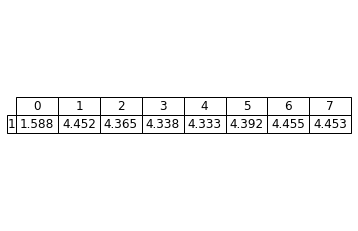

In [6]:
average_timing_info = {freq : [0 for i in range(TAU_MAX)] for freq in FREQUENCY_MULTIPLIERS}
for trial in range(0, NUM_TRIALS):
    timing_info, input_freq = get_data_per_trial(timing_info_per_tau_per_freq, actual_frequencies_per_freq, trial)
#     print(timing_info)
    for key in timing_info:
        for index,num in enumerate(timing_info[key]):
            timing_info[key][index] = round(num,3)
    generate_runtime_table(timing_info, input_freq, trial, 2)
#     for key in timing_info:
#         for index,num in enumerate(timing_info[key]):
#             average_timing_info[key][index] += num
            
for key in timing_info:
    for index,num in enumerate(timing_info[key]):
        average_timing_info[key][index] = round(num,3)
# fig = generate_runtime_table(average_timing_info, input_freq, trial)
    



In [13]:
'''
data buffer for mvp output
'''
completed_states = completed_states_per_tau_per_freq[1][0]
percent_valid = [0 for i in range(len(completed_states[0]))]
percent_valid_per_tau = [copy.copy(percent_valid) for i in range(TAU_MAX)]
wrong_towers_per_tau = [copy.copy(percent_valid) for i in range(TAU_MAX)]
wrong_tower_per_tau_over_time = [0 for i in range(len(completed_states[0][0]))]
number_requests_per_TAU = [0 for i in range(len(completed_states[0]))]
# print(completed_states[0][0])
# print(completed_states_per_tau_per_freq[1][0][0][0][0]) freq, something, tau, tower, state
states_per_tau = [0 for i in range(TAU_MAX)]
for tau,completed in enumerate(completed_states):
    for index, com in enumerate(completed):
        for state in com:
            if("VALID" in state.labels):
                percent_valid_per_tau[tau][index] += 1
            states_per_tau[tau] += 1
            for req in state.request_vector:
                if req == 'wrong_tower':
                     wrong_towers_per_tau[tau][index] += 1
                     wrong_tower_per_tau_over_time[index] += 1
                    
print(completed_states[0][0])
sums = [sum(i) for i in wrong_towers_per_tau]
print(sums)          
other_sums = [sum(i)/states_per_tau[tau] for tau, i in enumerate(percent_valid_per_tau)]
print(other_sums)

    

# for tower_cost in percent_valid_per_tau:
#     print(tower_cost)
# mvp_output_per_tower_per_tau_copy = copy.deepcopy(mvp_output_per_tower_per_tau)
# for tau in mvp_output_per_tower_per_tau_copy:
#     for output in tau:
#         gm.print_formatted_cost(output[0],format_override=True)
# for timings in timing_info:
#     print(sum(timings))
#     print (timings)
    

[State currently has requests :: () Time states of :: () Port states of :: {'no_pref': 3} Labels :: ('VALID', 'FINISH')  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
, State currently has requests :: () Time states of :: () Port states of :: {'0': 6} Labels :: ('VALID', 'FINISH')  
, State currently has requests :: () Time states of :: () P

No handles with labels found to put in legend.


[478, 18, 11, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

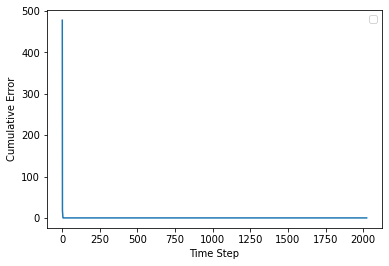

In [15]:
'''
More data processing
'''
# sum up the negative costs for the tower (get total expiration value)
cost_per_tau_over_time = [[] for i in range(TAU_MAX)]
for index,tau in enumerate(completed_states):
    sum_cost = 0
    for time_step in range(len(completed_states[0][0])):
        for tower in tau:
            for expiration in tower[time_step].time_vector:
                if expiration < 0:
                    sum_cost -= expiration 
#                     sum_cost +=1
        cost_per_tau_over_time[index].append(sum_cost)
cost_per_tau_over_time = cost_per_tau_over_time
'''
first plot:
cummulative expiration cost vs. time step
label with periods of high traffic and low traffic
do a line per tau
'''
x = [i+1 for i in range(len(completed_states[0][0]))]
print(wrong_tower_per_tau_over_time)
plt.plot(x, wrong_tower_per_tau_over_time)
# for tau_num, tau in enumerate(cost_per_tau_over_time):
#     plt.plot(x, tau, label = "TAU = " + str(tau_num))
plt.legend()
plt.xlabel('Time Step')
plt.ylabel('Cumulative Error')
plt.show()


In [19]:
'''
second plot:
cummulative expiration cost vs. time step
label with periods of high traffic and low traffic
do a line per tau
also include a line for the traffic over time
'''

cum_input_len_over_time = [0 for i in x]
for time_step in range(len(input)):
    if time_step > 0:
        cum_input_len_over_time[time_step] = cum_input_len_over_time[time_step-1]  
    for key in input[time_step][0].keys():
        cum_input_len_over_time[time_step] += len(input[time_step][0][key])
print (cum_input_len_over_time)
for i in range(len(input), len(x)):
    cum_input_len_over_time[i] = cum_input_len_over_time[i-1]

fig,ax1 = plt.subplots()
# print (cost_per_tau_over_time[4])
for tau_num, tau in enumerate(cost_per_tau_over_time):
    ax1.plot(x, tau, label = "TAU = " + str(tau_num))
plt.legend()
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Cumulative Error')
input_len_over_time = [0 for i in x]
for time_step in range(len(input)):
    for key in input[time_step][0].keys():
        input_len_over_time[time_step] += len(input[time_step][0][key])
ax2 = ax1.twinx()
ax2.bar(x, input_len_over_time, color='r', alpha=0.1)
# ax2.plot(x, cum_input_len_over_time, 'r.')
ax2.set_ylabel('Additional Requests')
ax2.tick_params('y',colors='r')
if USE_PURDUE_DATA:
    plt.savefig('data/Realtime/OpsLimits/cumulative_error_over_time_with_requests' + str(randrange(0,100000)) + '.png',dpi=216)    
else:
    plt.savefig('data/Realtime/cumulative_error_over_time_with_requests' + str(randrange(0,100000)) + '.png',dpi=216)

TypeError: object of type 'method' has no len()

In [11]:
'''
second plot:
traffic over time
'''
input_len_over_time = [0 for i in x]
for time_step in range(len(input)):
    for key in input[time_step][0].keys():
        input_len_over_time[time_step] += len(input[time_step][0][key])
plt.bar(x, input_len_over_time)


TypeError: object of type 'method' has no len()

In [ ]:
'''
timings data
'''
for timings in timing_info:
#     print(timings)
    print(sum(timings))